# <font face="garamond" size="18" color="#122DAC">***Multiple Regression***</font>
## <font face="garamond" size="6" color="#122DAC">*Econ 430*</font>

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random; random.seed(10) # pre-setting seed
from scipy import stats
from scipy.stats import norm, chi2, f
# Numpy version matters for scipy

# For model fitting
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.graphics import regressionplots
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Subset regressions & feature selection
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Boruta
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from boruta_shap import BorutaShap # use .py file version

# Heteroskedasticity
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, het_goldfeldquandt

# Missing data imputation
from sklearn.impute import KNNImputer
from statsmodels.imputation import mice


# For R kernel
# Note: need working copy of R, initiate chunk with `%%R`
import rpy2.ipython
%load_ext rpy2.ipython

# <font face="garamond" size="14" color="#122DAC">1. Building Models</font>

The Multiple Linear Regression (MR) model is a natural extension of the SLR framework that allows for many predictors. However, the model is still **linear in the parameters** and thus, has the form $$y= \beta_1 + \beta_2 x_2 + \beta_3 x_3 + \dots + \beta_k x_k + e,$$ where the parameters $\beta_k = \partial E[y]/\partial x_k$ are referred to as the *partial marginal effects*. The assumptions of the model are given in the table below:

<img src="images/L2_fig1.png" alt="Multiple regression assumptions" width="750">

When working with more than one predictor there are many more issues that may arise when building an appropriate model. Some of the more common ones are:

1. Multicollinearity
2. Omitted Variable Bias
3. Variable Selection
4. Irrelevant Variables
5. Heteroskedasticity
6. Model Misspecification

We will discuss each one in detail and learn how to mitigate them but first we will introduce the subject with a simple example. Consider the U.S. Gasoline Market. We will estimate a model for gasoline consumption/person using the predictors income/person, price of a gallon of gasoline, price of new cars, and price of used cars. We will consider taking logs to help equalize the variances. The model is therefore:

$$\log(G/pop) = \beta_1 + \beta_2 \log(income/pop) + \beta_3 \log(price) + \beta_4 \log(price_{new}) + \beta_5 \log(price_{used}) +e$$  
***Question:*** *What is the sign of $\beta_4$?* Cars and gasoline are complements:

* If the prices of new cars rise, then gasoline consumption should fall, i.e., $\beta_4<0$.
* If the prices of new cars rise, consumers will buy fewer of them; keep their used cars longer, but if older cars use more gasoline than newer ones, consumption should increase, i.e., $\beta_4>0$.

In [2]:
# Import data: US gasoline
usgas = pd.read_csv('data/USGasG.csv', index_col=0) # Note: income already per capita

# Fit model
usgas_mod = smf.ols('np.log(gas/population) ~ np.log(income) + np.log(price) + np.log(newcar) + np.log(usedcar)',
                    data=usgas).fit()

# Model summary
print(usgas_mod.summary())
# Recall b_4 is coefficient for log(newcar)
# It looks like economic theory wins since beta_4 < 0.

                               OLS Regression Results                               
Dep. Variable:     np.log(gas / population)   R-squared:                       0.958
Model:                                  OLS   Adj. R-squared:                  0.953
Method:                       Least Squares   F-statistic:                     176.7
Date:                      Wed, 16 Oct 2024   Prob (F-statistic):           7.29e-21
Time:                              08:41:26   Log-Likelihood:                 74.373
No. Observations:                        36   AIC:                            -138.7
Df Residuals:                            31   BIC:                            -130.8
Df Model:                                 4                                         
Covariance Type:                  nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

## 1.1 Simple Models
Consider a model for sales revenue (in $\$$ 1000s) as a function of advertising expenditure (in $\$$ 1000s) and price/burger of a local burger restaurant. Our model is: $SALES = \beta_1 + \beta_2PRICE + \beta_3ADVERT +e$.

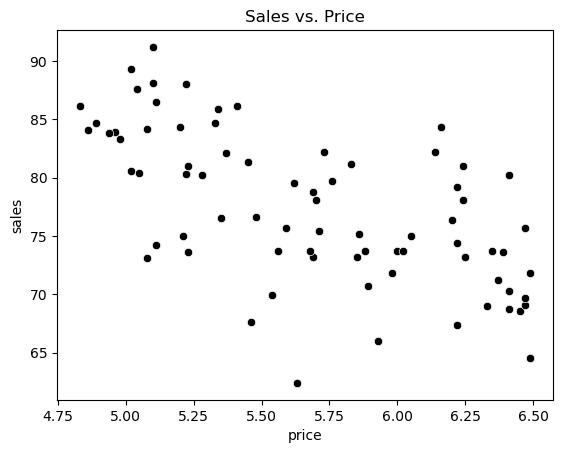

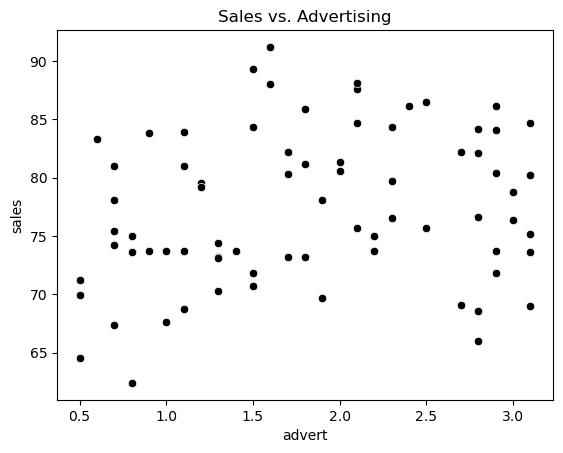

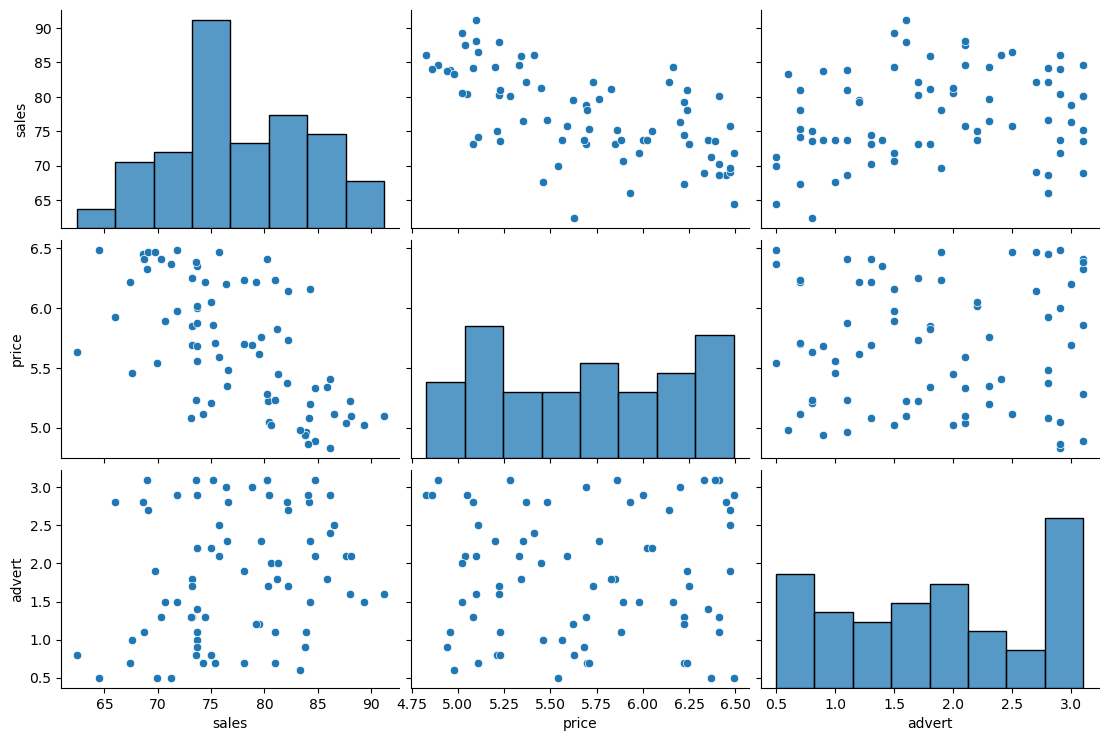

In [3]:
# Example 1: Sales Revenue (y=sales) vs. Price (x1=price) & Advertising Expenditure (x2=advert)

# Import data: burger restaurant (andy)
andy = pd.read_csv('data/andy.csv')

# Scatterplots
sns.scatterplot(data=andy, y='sales', x='price', color='black')
plt.title('Sales vs. Price')
plt.show()
sns.scatterplot(data=andy, y='sales', x='advert', color='black')
plt.title('Sales vs. Advertising')
plt.show()

# Pair-wise scatterplot
sns.pairplot(andy, aspect=1.5)
plt.show()

# We'll go more in depth in the next code chunk

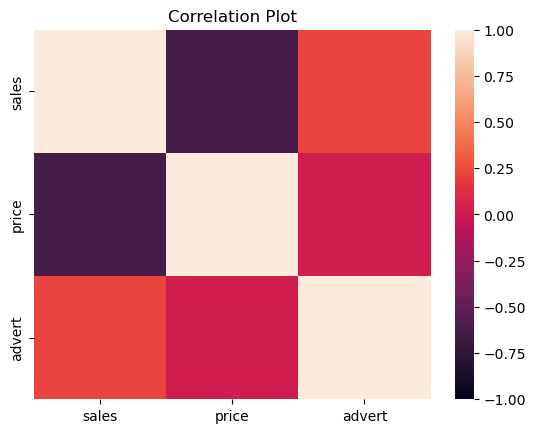

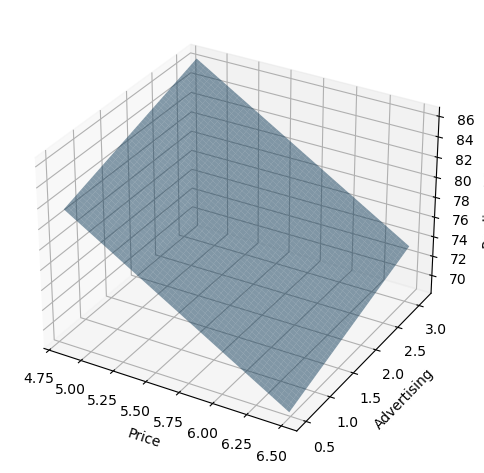

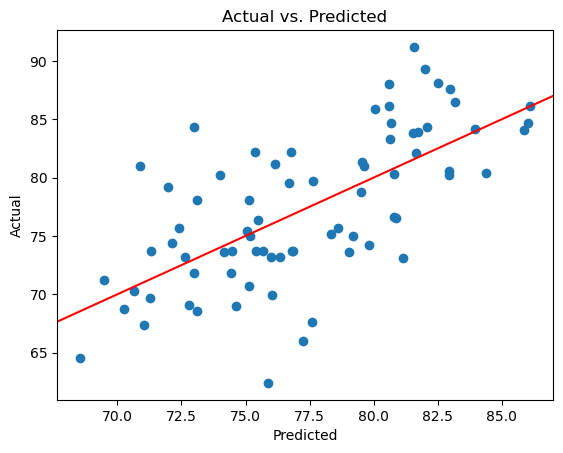

In [4]:
# Correlation plot
andy_corr = andy.corr() # correlation matrix
sns.heatmap(andy_corr, vmin=-1, vmax=1)
plt.title('Correlation Plot')
plt.show()

# Fit model
andy_mod = smf.ols('sales ~ price + advert', data=andy).fit()
andy_b1, andy_b2, andy_b3 = andy_mod.params # y = b1 + b2 x2 + b3 x3

# Hyperplane of model
## Generate values spanning x and y
andy_span_price = np.linspace(np.quantile(andy['price'], 0), np.quantile(andy['price'], 1), 200)
andy_span_advert = np.linspace(np.quantile(andy['advert'], 0), np.quantile(andy['advert'], 1), 200)
andy_plot_price, andy_plot_advert = np.meshgrid(andy_span_price, andy_span_advert)

## Calculate predicted values on hyperplane (z)
andy_span_pred = andy_b1 + andy_b2*andy_plot_price + andy_b3*andy_plot_advert

## Plot the hyperplane
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot_surface(andy_plot_price, andy_plot_advert, andy_span_pred, alpha=0.5)
ax1.set_xlabel('Price')
ax1.set_ylabel('Advertising')
ax1.set_zlabel('Predicted Sales') # label does not show up well
plt.tight_layout()
plt.show()

# Actual vs predicted
## To visually inspect the fit we can plot y vs y_hat. A perfect fit would look like a line at 45 degrees
plt.scatter(x=andy_mod.fittedvalues, y=andy['sales'])
plt.axline(xy1=(80,80), slope=1, color='red')
plt.title('Actual vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     29.25
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           5.04e-10
Time:                        08:41:27   Log-Likelihood:                -223.87
No. Observations:                  75   AIC:                             453.7
Df Residuals:                      72   BIC:                             460.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    118.9136      6.352     18.722      0.0

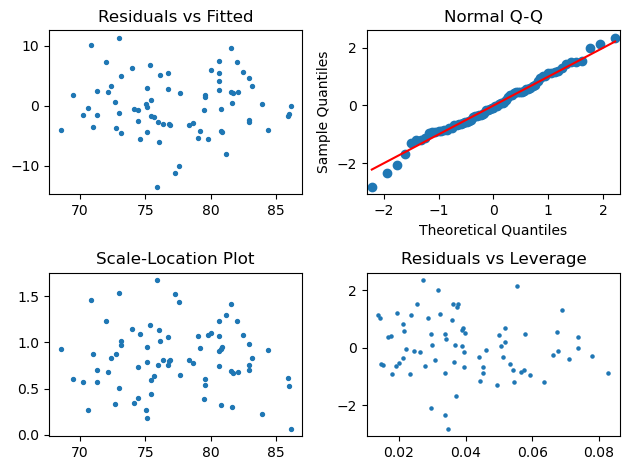

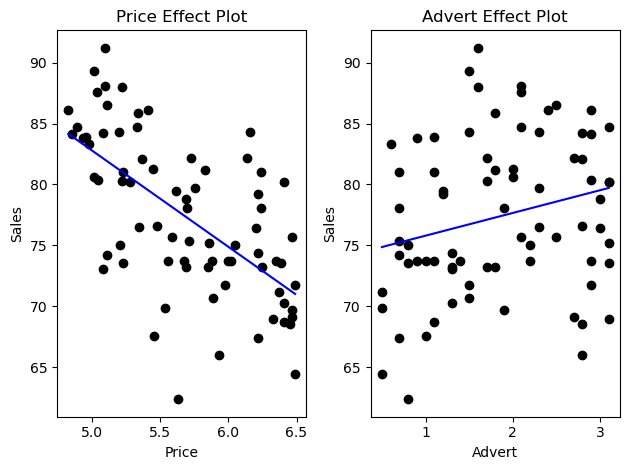

In [5]:
# Then we can look at the standard regression outputs

# Some calculations on residuals
andy_mod_std_resid = andy_mod.get_influence().resid_studentized_internal # standardized residuals
andy_mod_lev = andy_mod.get_influence().hat_matrix_diag # leverage values

# Summary
print(andy_mod.summary())

# Diagnostic plots
fig2, ax2 = plt.subplots(2, 2)
ax2[0,0].scatter(x=andy_mod.fittedvalues, y=andy_mod.resid, s=8)
ax2[0,0].set_title('Residuals vs Fitted')
sm.qqplot(andy_mod_std_resid, line='s', ax=ax2[0,1])
ax2[0,1].set_title('Normal Q-Q')
ax2[1,0].scatter(x=andy_mod.fittedvalues, y=np.sqrt(np.abs(andy_mod_std_resid)), s=8) # y = sqrt( |std. resid| )
ax2[1,0].set_title('Scale-Location Plot')
ax2[1,1].scatter(x=andy_mod_lev, y=andy_mod_std_resid, s=5)
ax2[1,1].set_title('Residuals vs Leverage')
plt.tight_layout()

# Effects plots
## Note: To do by hand, only vary one predictor at a time, set all others to their means
fig3, ax3 = plt.subplots(1, 2)
ax3[0].scatter(andy['price'], andy['sales'], color='black')
ax3[0].plot(andy_span_price, andy_b1 + andy_b2*andy_span_price + andy_b3*np.mean(andy['advert']), color='b')
ax3[0].set_title('Price Effect Plot')
ax3[0].set_xlabel('Price')
ax3[0].set_ylabel('Sales')
ax3[1].scatter(andy['advert'], andy['sales'], color='black')
ax3[1].plot(andy_span_advert, andy_b1 + andy_b2*np.mean(andy['price']) + andy_b3*andy_span_advert, color='b')
ax3[1].set_title('Advert Effect Plot')
ax3[1].set_xlabel('Advert')
ax3[1].set_ylabel('Sales')
plt.tight_layout()


A popular econometric operation is to compute combinations of parameters. For example, assume Andy's marketing team asks you to test if increasing adverting by $\$800$/month and lowering their prices by $\$0.40$/burger will lead to higher revenue sales than their current marketing strategy of $\$1500$/month and \$0.20 respectively? 

We can address this by estimating the regression $SALES = \beta_1 + \beta_2PRICE + \beta_3ADVERT +e$, and once we have the parameter estimates, we can compute $\widehat{\lambda} = c_1 \widehat{\beta}_2 + c_2\widehat{\beta}_3$, where $c_1$ and $c_2$ are constants (they will be replaced with the values of $PRICE$ and $ADVERT$ respectively).  For example, for the proposed marketing strategy, $\widehat{\lambda} = -0.4\widehat{\beta}_2 + 0.8\widehat{\beta}_3$.

Note that the above test is *not* a joint hypothesis test, but rather a simlutaneous hypothesis test involving multiple parameters. For these you can use a t-test (the `t_test` method) or F-test (the `f_test` method), but joint hypotheses can only be done using an F-test. If you are testing a hypothesis that the constrained model equals 0 e.g., $-0.4\widehat{\beta}_2 + 0.8\widehat{\beta}_3=0$, the only input will be the vector or matrix of constraints. In this case: `[0, -0.4, 0.8]`, for joint hypotheses, you would make a numpy array with each row being its own hypothesis. If the constrained model does not equal 0, the input will be a tuple, where the first argument is the array/list of hypotheses, and the second argument will be what the constraints equal, either a value for simple hypotheses or a list for joint.

In [6]:
# Example 1 (continued)
## Sales Revenue (y=sales) vs. Price (x1=price) & Advertisement (x2=advert)

# t-test 1
andy_mod_t1 = andy_mod.t_test(np.array([0., -0.4, 0.8])) # constraints: c2 = -0.4, c3 = 0.8; 0 indicates no constraint
print(andy_mod_t1.summary(), '\n\n\n')
# Output interpretation: The expected sales revenue from this marketing strategy is $4,652
# Equivalent F-test: andy_mod.f_test(np.array([0, -0.4, 0.8]))

# t-test 2
andy_mod_t2 = andy_mod.t_test(np.array([0., -0.2, 1.5])) # constraints: c2 = -0.2, c3 = 1.5
print(andy_mod_t2.summary())
# Output interpretation: The expected sales revenue from this marketing strategy is $4,375
# Equivalent F-test: andy_mod.f_test(np.array([0., -0.2, 1.5]))

# The proposed strategy appears to be better for revenue.

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             4.6532      0.710      6.557      0.000       3.239       6.068



                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             4.3754      1.054      4.153      0.000       2.275       6.476


In [7]:
# Q: Assume Andy is not doing too well financially, and they need at least $5800 in monthly sales revenue.
# How would you test if their proposed marketing strategy will help them meet this requirement?

# Method 1:
## Hypothesis test: -0.4*price + 0.8*advert =? 5.8
andy_mod_hyp = andy_mod.t_test(([0., -0.4, 0.8], 5.8))
print(andy_mod_hyp.summary(), "\n\n")
# Result: look's like they stay in business!
# Equivalent F-test: andy_mod.f_test(([0., -0.4, 0.8], 5.8))

# Method 2:
## Confidence interval: [low, high]
andy_mod_conf = andy_mod.t_test(np.array([0., -0.4, 0.8]))
print('Confidence interval: ', andy_mod_conf.conf_int())
# Result: Still in business, but $5800 is too close to the upper bound of $60k.

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             4.6532      0.710     -1.616      0.110       3.239       6.068


Confidence interval:  [[3.23862099 6.06779731]]


The previous example failed to capture the expected diminishing returns effect for advertising. We may account for this by also including a quadratic term in the model. For example, we might consider
$$sales = \beta_1 + \beta_2 price + \beta_3 advert + \beta_4 advert^2 +e.$$

If $\beta_4 <0$, our intuition would be correct, and in fact, we can even ask and check what is the optimal level of advertising. We can do this by solving for the the *marginal effect* of advertising on sales, $ME = \frac{\partial (sales)}{\partial (advert)} = \beta_3 + 2\beta_4 advert =1$. Why do we set it equal to 1 and not 0? Andy will advertise up to the point where another \$1 of expenditure adds \$1 of sales.

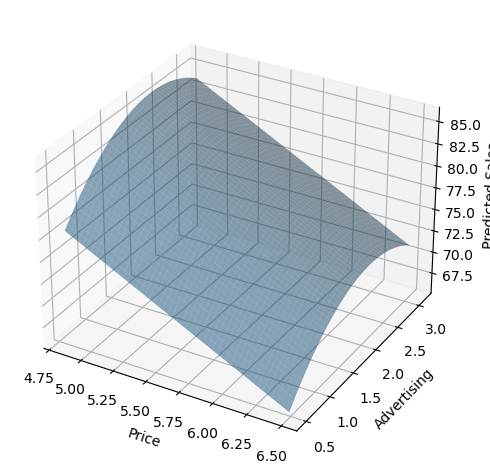

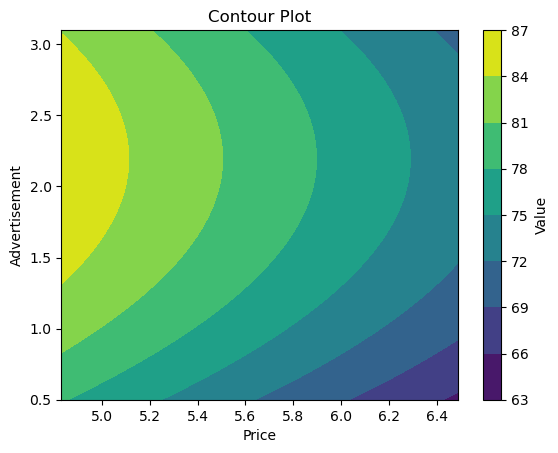

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     24.46
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           5.60e-11
Time:                        08:41:28   Log-Likelihood:                -219.55
No. Observations:                  75   AIC:                             447.1
Df Residuals:                      71   BIC:                             456.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        109.7190      6.799     16.

In [8]:
# Example 2:
## Sales Revenue (y=sales) vs. Price (x1=price) & Advertising Expenditure (x2 = advert, x3 = advert^2)

andy_mod2 = smf.ols('sales ~ price + advert + I(advert**2)', data=andy).fit()
andy_m2_b1, andy_m2_b2, andy_m2_b3, andy_m2_b4 = andy_mod2.params # y = b1 + b2 x2 + b3 x3 + b4 x3 ^ 2

# Hyperplane of model
## Using xy grid generated earlier: andy_plot_price, andy_plot_advert

## Calculate predicted values on hyperplane (z)
andy_m2_span_pred = andy_m2_b1 + andy_m2_b2*andy_plot_price + andy_m2_b3*andy_plot_advert + andy_m2_b4*andy_plot_advert**2

## Plot the hyperplane
fig4 = plt.figure()
ax4 = fig4.add_subplot(111, projection='3d')
ax4.plot_surface(andy_plot_price, andy_plot_advert, andy_m2_span_pred, alpha=0.5)
ax4.set_xlabel('Price')
ax4.set_ylabel('Advertising')
ax4.set_zlabel('Predicted Sales') # label does not show up well
plt.tight_layout()
plt.show()

# Contour plot
plt.contourf(andy_plot_price, andy_plot_advert, andy_m2_span_pred, cmap='viridis')
plt.colorbar(label='Value')
plt.ylabel('Advertisement')
plt.xlabel('Price')
plt.title('Contour Plot')
plt.show()

# Model summary
print(andy_mod2.summary())

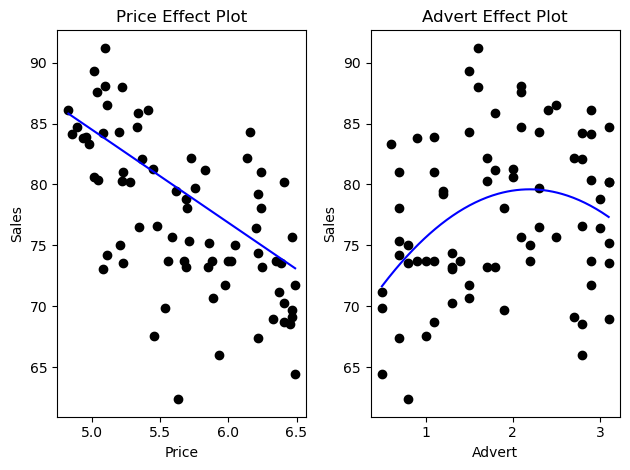

In [9]:
# Effects plots

fig5, ax5 = plt.subplots(1, 2)
ax5[0].scatter(andy['price'], andy['sales'], color='black')
ax5[0].plot(andy_span_price, andy_m2_b1 + andy_m2_b2*andy_span_price + andy_m2_b3*np.mean(andy['advert']) + andy_m2_b4*np.mean(andy['advert'])**2, color='b')
ax5[0].set_title('Price Effect Plot')
ax5[0].set_xlabel('Price')
ax5[0].set_ylabel('Sales')
ax5[1].scatter(andy['advert'], andy['sales'], color='black')
ax5[1].plot(andy_span_advert, andy_m2_b1 + andy_m2_b2*np.mean(andy['price']) + andy_m2_b3*andy_span_advert + andy_m2_b4*andy_span_advert**2, color='b')
ax5[1].set_title('Advert Effect Plot')
ax5[1].set_xlabel('Advert')
ax5[1].set_ylabel('Sales')
plt.tight_layout()

> *From the effects plots, what would be the optimal level of advertising?*

To answer that question, we can look to the **average marginal effects** for each variable. With your basic linear model, the marginal effect is of course just the slope for the particular variable. But with higher-order terms, interaction effects, or other non-linear modifications, we have to use calculus and some statistics to find the effect and its statistical significance. This process is very similar to the computations we did for the effects plots.

In R, `margins()` in the `margins` package is a very easy help for these computations. Unfortunately, there isn't yet an equivalent in Python, so we will do it by hand.

Continuing with the Andy data set, let's first look at the variable "price". As this variable is included only as first order term, the average marginal effect will be the coefficient estimate. The standard error will be the square root of the variance for the parameter estimate (in the variance-covariance matrix). Let's try it now:

In [10]:
# Estimating the Average Marginal Effect (AME) for "price", call it x1

andy_x1ame_se = np.sqrt(np.diag(andy_mod2.cov_params()))[1] # standard error
andy_x1ame_z = andy_m2_b2 / andy_x1ame_se # z-score
andy_x1ame_p = stats.norm.cdf(andy_x1ame_z) * 2 # if z > 0, use survival function (sf = 1 - CDF)
andy_x1ame_confint = stats.norm.interval(0.95, loc=andy_m2_b2, scale=andy_x1ame_se) # confidence interval
print(f'AME: \t {andy_m2_b2:.4f}\n' +
      f'se: \t {andy_x1ame_se:.4f}\n' +
      f'z: \t {andy_x1ame_z:.4f}\n' + 
      f'p: \t {andy_x1ame_p:.4f}\n' +
      f'low,high: ({andy_x1ame_confint[0]:.4f},{andy_x1ame_confint[1]:.4f})')

AME: 	 -7.6400
se: 	 1.0459
z: 	 -7.3044
p: 	 0.0000
low,high: (-9.6900,-5.5900)


We'll try the same for "advert" next, which we will call $x_2$ for simplicity. First, let's compute the AME:
$$
AME = \left.\frac{\partial}{\partial x_2}\left[b_1 + b_2 x_1 + b_3 x_2 + b_4 x_2 ^2\right]\right|_{\bar x_2} = b_3 + 2b_4 \bar x_2
$$
Then we can compute the standard error as being the square root of the variance of the AME.
\begin{align*}
\mathrm{Var}(AME) &= \mathrm{Var}(b_3 + 2b_4 \bar x_2) \\
&= \mathrm{Var}(b_3) + 4\bar x_2^2\ \mathrm{Var}(b_4) + 4\bar x_2 \mathrm{Cov}(b_3, b_4) \\
\Rightarrow se(AME) &= \sqrt{\mathrm{Var}(b_3) + 4\bar x_2^2\ \mathrm{Var}(b_4) + 4\bar x_2 \mathrm{Cov}(b_3, b_4)}
\end{align*}

In [11]:
# Estimating the Average Marginal Effect (AME) for "advert", call it x2

andy_x2ame = andy_m2_b3 + 2 * andy_m2_b4 * np.mean(andy['advert']) # b3 + 2 * b4 * x2
andy_x2ame_var = (np.diag(andy_mod2.cov_params())[2] + 4 * np.diag(andy_mod2.cov_params())[3] * np.mean(andy['advert'])**2 +
                  4 * np.mean(andy['advert']) * andy_mod2.cov_params().to_numpy()[2,3]) # covariance term
andy_x2ame_se = np.sqrt(andy_x2ame_var) # standard error
andy_x2ame_z = andy_x2ame / andy_x2ame_se # z-score
andy_x2ame_p = stats.norm.sf(andy_x2ame_z) * 2 # since z > 0, using survival function (sf = 1 - CDF)
andy_x2ame_confint = stats.norm.interval(0.95, loc=andy_x2ame, scale=andy_x2ame_se) # confidence interval
print(f'AME: \t {andy_x2ame:.4f}\n' +
      f'se: \t {andy_x2ame_se:.4f}\n' +
      f'z: \t {andy_x2ame_z:.4f}\n' + 
      f'p: \t {andy_x2ame_p:.4f}\n' +
      f'low,high: ({andy_x2ame_confint[0]:.4f},{andy_x2ame_confint[1]:.4f})')

AME: 	 1.9430
se: 	 0.6501
z: 	 2.9888
p: 	 0.0028
low,high: (0.6688,3.2171)


In [12]:
%%R
# Using R will likely be easier instead of calculating by hand

library(margins)
andy <- read.csv("data/andy.csv")

# Fit model
andy_mod2 <- lm(sales ~ price + advert + I(advert^2), data = andy)

# Marginal effects
andy_mod2_margin <- margins(andy_mod2)
summary(andy_mod2_margin)


 factor     AME     SE       z      p   lower   upper
 advert  1.9430 0.6501  2.9888 0.0028  0.6688  3.2171
  price -7.6400 1.0459 -7.3044 0.0000 -9.6900 -5.5900


For Andy's Burger example, we could mathematically compute the optimal level of advertising by simply solving $ME = \frac{\partial\ sales}{\partial\ advert} =0$. In this case, however, we have a nonlinear function of the parameters, namely, $ME = 0 \iff \beta_3 + 2\beta_4 advert= 0 \Rightarrow advert^*= -\beta_{3}/2\beta_4$. Since we have the estimates $b_3$ and $b_4$, a point estimate of $ME$ can be readily obtained as well. However, this marginal effect is a nonlinear function of the parameters, and therefore, the respective standard error is not as trivial to obtain. We can use the *Delta Method* to estimate the standard error for any nonlinear combination of parameters. For example, in our case, let $\lambda = -\beta_{3}/2\beta_4$, then we can estimate the variance as:

$$
{\rm var}(\widehat{\lambda})
=\left(\frac{\partial \lambda}{\partial \beta_3} \right) {\rm var}(b_3)   + \left( \frac{\partial \lambda}{\partial \beta_4} \right){\rm var}(b_4) + 2\left(\frac{\partial \lambda}{\partial \beta_3} \right)\left(\frac{\partial \lambda}{\partial \beta_4}  \right) {\rm cov}(b_3, b_4)
$$

Instead of the above, which can get complicated, we can try using multivariable calculus. We have the function $G(\beta)=-\beta_{3}/2\beta_4$, and its associated Jacobian $$J=\nabla G=\begin{bmatrix} - \frac{1}{2\beta_4} \\ - \frac{\beta_3}{2{\beta_4}^2} \end{bmatrix}.$$
We can then estimate the variance as $$\rm{Var}(\hat \lambda)\approx J^T C J $$
where $C$ is the covariance matrix for the included variables (in this case, only $\beta_3$ and $\beta_4$).


The standard error is simply $\sqrt{{\rm var}(\widehat{\lambda}) }$. Below is an example of how to do this in R, using the `car` package.

In [13]:
# Example 3: Delta Method
# Sales Revenue (y=sales) vs. Price (x1 = price) & Advertising Expenditure (x2 = advert + x3 = advert^2)

# Optimal level of advertising by hand
andy_opt_ad = -andy_m2_b3 / (2 * andy_m2_b4) # G, our function
andy_opt_J = np.array([-0.5/andy_m2_b4, andy_m2_b3 / (2*andy_m2_b4**2)]) # Jacobian
andy_opt_cov = andy_mod2.cov_params().to_numpy()[2:4,2:4] # covariance matrix, only b3 and b4
andy_opt_se = np.sqrt(andy_opt_J @ andy_opt_cov @ andy_opt_J) # standard error
andy_opt_confint = stats.norm.interval(0.95, loc=andy_opt_ad, scale=andy_opt_se) # confidence interval

print(f'estimate: \t{andy_opt_ad:.5f}\n' +
      f'se: \t\t{andy_opt_se:.5f}\n' +
      f"low,high: \t{andy_opt_confint[0]:.5f},{andy_opt_confint[1]:.5f}")

estimate: 	2.19498
se: 		0.16382
low,high: 	1.87389,2.51607


In [14]:
%%R

# Example 3 in R, using `car` package
library(car)

deltaMethod(andy_mod2, "-b3/(2*b4)", parameterNames = paste("b", 1:4, sep = ""))
# From the output it looks like the optimal level is $2,195.

             Estimate      SE   2.5 % 97.5 %
-b3/(2 * b4)  2.19498 0.16382 1.87389 2.5161


Loading required package: carData


## 1.2 Models with Factors and Interactions

The multiple regression framework can easily be extended to include factor variables and interactions between the predictors. In this section we will discuss the following models:

* One Factor (ANOVA)
* One Factor and Several Quantitative Variables (ANCOVA)
* Many Factors (MANOVA)
* Several Factors and Quantitative Variables
* Interaction Terms

### 1.2.1 A Model with One Factor (ANOVA)

We can consider a linear regression model where there are no predictors and the response variable is an indicator variable. This model is known as a 'One-Way Analysis of Variance (ANOVA)'. Following the textbooks example, consider the study by Moore and McCabe, 1993, on teaching reading using 3 different methods (Standard =`Basal` (baseline or control group), New method 1 = `DTRA`, and New method 2 = `Strat`). The data consist of 2 pretests and 3 post tests of reading comprehension, but we will only focus on the third post test.

   group  pretest.1  pretest.2  post.test.1  post.test.2  post.test.3
0  Basal          4          3            5            4           41
1  Basal          6          5            9            5           41
2  Basal          9          4            5            3           43
3  Basal         12          6            8            5           46
4  Basal         16          5           10            9           46 

group
Basal    22
DRTA     22
Strat    22
Name: count, dtype: int64 

            mean        sd
group                     
Basal  41.045455  5.635578
DRTA   46.727273  7.388420
Strat  44.272727  5.766750


Text(0.5, 1.0, 'Reading Score by Group')

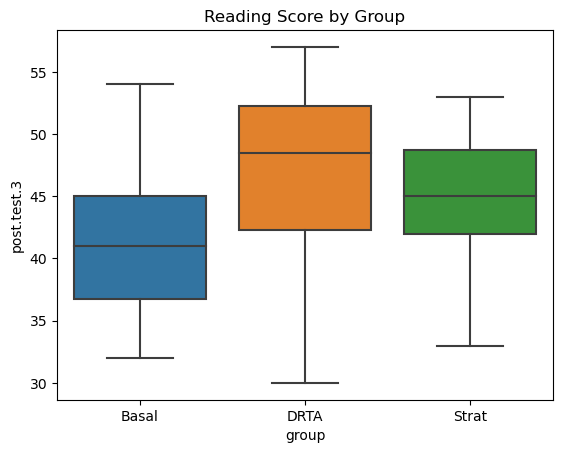

In [15]:
# Example 4: Reading Compression Scores based on Different Teaching Methods

# Import and preview data
baumann = pd.read_csv('data/baumann.csv')
print(baumann.head(), '\n')

# Number observations in each group
print(baumann['group'].value_counts(), '\n')

# Group means & standard deviation for "post test 3"
print(
    pd.DataFrame({
        'mean':baumann.groupby('group').mean()['post.test.3'],
        'sd':baumann.groupby('group').std()['post.test.3']
    })
)

# Box plots
sns.boxplot(data=baumann, x='group', y='post.test.3')
plt.title('Reading Score by Group')

In [16]:
# Estimating ANOVA model

baumann2 = baumann.rename({'post.test.3':'post_test_3'}, axis=1) # change "." to "_" in column name
baumann_mod = smf.ols('post_test_3 ~ group', baumann2).fit()
print(baumann_mod.summary())

# Estimates are the differences in reading scores between the baseline "Basal" group and the other individual groups
# Y-intercept is the mean of the baseline group.

# You can change the reference group with `C(variable, Treatment(reference="level"))`
# Example: smf.ols('post_test_3 ~ C(group, Treatment(reference="DRTA"))', baumann2)

                            OLS Regression Results                            
Dep. Variable:            post_test_3   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     4.481
Date:                Wed, 16 Oct 2024   Prob (F-statistic):             0.0152
Time:                        08:41:28   Log-Likelihood:                -213.74
No. Observations:                  66   AIC:                             433.5
Df Residuals:                      63   BIC:                             440.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         41.0455      1.346     30.

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 Basal   DRTA   5.6818 0.0111  1.1121 10.2515   True
 Basal  Strat   3.2273  0.215 -1.3424   7.797  False
  DRTA  Strat  -2.4545 0.4064 -7.0242  2.1151  False
----------------------------------------------------


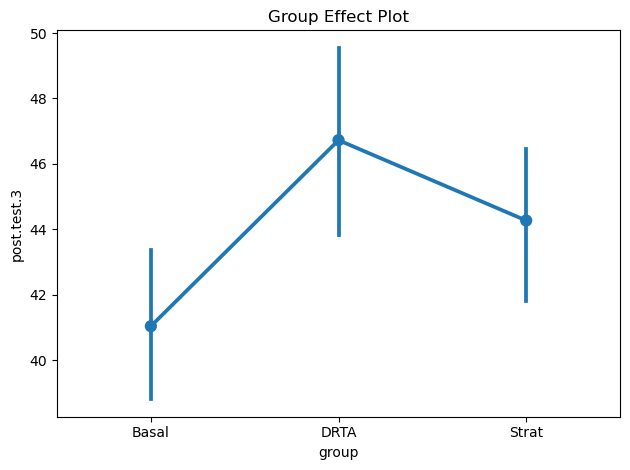

In [17]:
# ANOVA as multiple comparison
baumann_mod2 = MultiComparison(baumann['post.test.3'], baumann['group'])

# We can also do pair-wise comparisons, with p-value corrections
## H0: no significant difference in means
print(baumann_mod2.tukeyhsd())

# We can represent it visually too
sns.pointplot(baumann, x='group', y='post.test.3')
plt.title('Group Effect Plot')
plt.tight_layout()

### 1.2.2 A Model with One Factor and One Quantitative Variable (ANCOVA)

This case and the more general one where we can have more than one quantitative variable is known as `ANCOVA` for *Analysis of Covariance*. If the factor variable (call it $D$) is additive, it is known as an *Intercept Indicator Variable* because it has the effect of shifting the regression line by an amount $\delta$ which represents the estimated coefficient of $D$. For example, consider modeling home prices as a function of living area (`sqft`) and location (`D`): $PRICE = \beta_1 + \delta D + \beta_2 SQFT +e$. This suggests we have two regression lines:

$$
E(PRICE)  =
\begin{cases}
(\beta_1 +\delta) + \beta_2 SQFT & \text{when }D=1 \\
\beta_1 + \beta_2 SQFT & \text{when }D=0.
\end{cases}
$$


The effect of the dummy variable $D$ can be shown graphically as:


<img src="images/L2_fig2.png" alt="Intercept Dummy Variable" width="600">

To better understand this model, we will estimate the model above for the dataset "utown," where the variable `utown` is an indicator variable  = 1 (if the house located in the university town), and = 0 (otherwise).

In [18]:
# Example 5: Home Prices (y = price) vs. Area (x1 = sqft) + Location (D = utown)

utown = pd.read_csv('data/utown.csv')

# Fit model
utown_mod = smf.ols('price ~ utown + sqft', data=utown).fit()
print(utown_mod.summary(), '\n')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     3192.
Date:                Wed, 16 Oct 2024   Prob (F-statistic):               0.00
Time:                        08:41:28   Log-Likelihood:                -4159.7
No. Observations:                1000   AIC:                             8325.
Df Residuals:                     997   BIC:                             8340.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6809      4.290      1.324      0.1

In [19]:
# We can look at the adjusted means (fitted values at the various levels of the factor). 
# In our case, the factor utown only has two levels (= 0,1)

# Mean level when utown = 0
utown_mod_utown0 = utown_mod.params['Intercept'] + utown_mod.params['sqft']*utown['sqft'].mean()

# Print effect of utown level
print('utown\t effect')
for p in np.array([0, 0.2, 0.5, 0.8, 1.]):
    print(f'{p} \t {utown_mod_utown0 + utown_mod.params["utown"] * p:.4f}')

# Note: As expected, if you take the difference between the two effects (0 and 1), we get the coefficient of utown.

### Interpretation:
# There appears to be a statistically (p<0.05) and economically significant 
# "location premium" for houses located in University Town. For example,
# the same house would cost about $60k more in a University Town.

# Q: Does the result that this location premium is the same for all houses make subject-matter sense?

utown	 effect
0.0 	 216.3242
0.2 	 228.3980
0.5 	 246.5087
0.8 	 264.6194
1.0 	 276.6932


### 1.2.3 Model with Many Factors (MANOVA)

This class of models are referred to as Multiway ANOVA (MANOVA) which are simply multifactor regression models. These problems are typically characterized by examining the between and withing group variations. Following your textbook's example, we will look at the data by Moore and Krupat (1971) on partner status and conformity.

In [20]:
# Example 6: Conformity vs. Authoritarianism and Partner Status

# Preview data
moore = pd.read_csv('data/moore.csv').rename({'partner.status':'partner_status'}, axis=1)
moore.head()

,partner_status,conformity,fcategory,fscore
0,low,8,low,37
1,low,4,high,57
2,low,8,high,65
3,low,7,low,20
4,low,10,low,36


In [21]:
# Frequency table
pd.crosstab(moore['fcategory'], moore['partner_status'])

partner_status,high,low
fcategory,,
high,7,8
low,5,10
medium,11,4


In [22]:
# Stats for all level combinations
print(moore.groupby(['fcategory', 'partner_status'])['conformity'].mean()) # means
print(moore.groupby(['fcategory', 'partner_status'])['conformity'].std()) # standard deviation

fcategory  partner_status
high       high              11.857143
           low               12.625000
low        high              17.400000
           low                8.900000
medium     high              14.272727
           low                7.250000
Name: conformity, dtype: float64
fcategory  partner_status
high       high              3.933979
           low               7.347254
low        high              4.505552
           low               2.643651
medium     high              3.951985
           low               3.947573
Name: conformity, dtype: float64


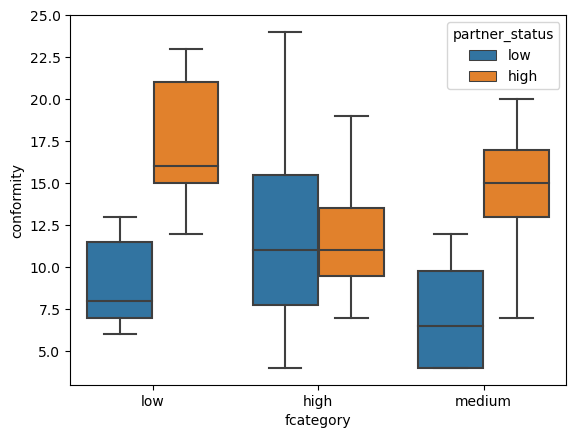

In [23]:
# Box plots
sns.boxplot(moore, x='fcategory', y='conformity', hue='partner_status')
plt.show()

                            OLS Regression Results                            
Dep. Variable:             conformity   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     3.734
Date:                Wed, 16 Oct 2024   Prob (F-statistic):            0.00740
Time:                        08:41:29   Log-Likelihood:                -129.10
No. Observations:                  45   AIC:                             270.2
Df Residuals:                      39   BIC:                             281.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

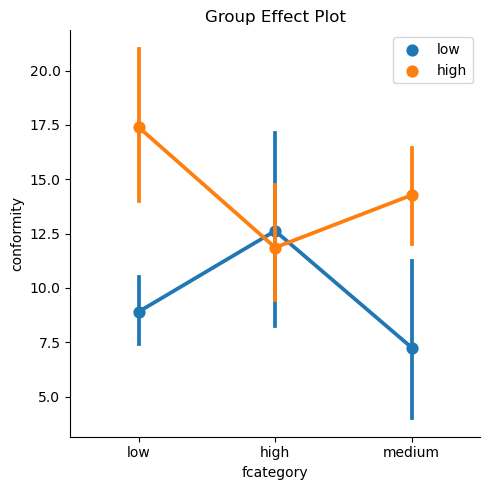

In [24]:
# MANOVA model
moore_mod = smf.ols('conformity ~ fcategory * partner_status', data=moore).fit()
print(moore_mod.summary())

# Effect plot
sns.catplot(moore, x='fcategory', y='conformity', hue='partner_status', kind='point', legend_out=False)
plt.title('Group Effect Plot')
plt.legend(loc = 'upper right')
plt.tight_layout()

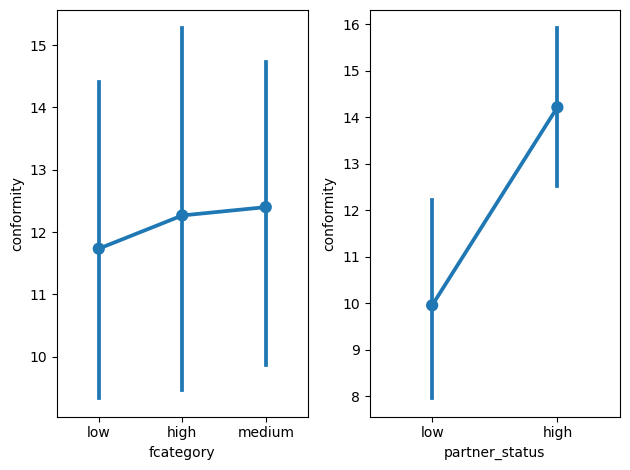

In [25]:
# We can remove the interaction term and review the main effects plot:
fig6, ax6 = plt.subplots(1, 2)
sns.pointplot(moore, x='fcategory', y='conformity', ax=ax6[0])
sns.pointplot(moore, x='partner_status', y='conformity', ax=ax6[1])
plt.tight_layout()

### 1.2.4 Model with Many Factors and Quantitative Variables

This model can be treated the same way as the one before but instead of two models, if we e.g., consider 2 factors, with two levels each, we now have 4 models to evaluate. Lets revisit the "prestige" data set.

In [26]:
# Example 7:
# Presige (y=prestige) vs. Education (x1=education), Income (x2=income) and Type (D=type)

prestige = pd.read_csv('data/prestige.csv', index_col=0)

# Store average values
avg_educ,avg_income,avg_women = prestige.drop(['prestige', 'type', 'census'], axis=1).agg('mean')
avg_prof = (prestige['type'] == 'prof').mean()
avg_wc = (prestige['type'] == 'wc').mean()

# Quick data summaries
print(prestige.describe(), '\n')
print(prestige['type'].value_counts(), '\n') # number per type
print('Missing values:', prestige['type'].isna().sum())

        education        income       women    prestige       census
count  102.000000    102.000000  102.000000  102.000000   102.000000
mean    10.738039   6797.901961   28.979020   46.833333  5401.774510
std      2.728444   4245.922227   31.724931   17.204486  2644.993215
min      6.380000    611.000000    0.000000   14.800000  1113.000000
25%      8.445000   4106.000000    3.592500   35.225000  3120.500000
50%     10.540000   5930.500000   13.600000   43.600000  5135.000000
75%     12.647500   8187.250000   52.202500   59.275000  8312.500000
max     15.970000  25879.000000   97.510000   87.200000  9517.000000 

type
bc      44
prof    31
wc      23
Name: count, dtype: int64 

Missing values: 4


                            OLS Regression Results                            
Dep. Variable:               prestige   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     137.6
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           3.51e-38
Time:                        08:41:29   Log-Likelihood:                -321.97
No. Observations:                  98   AIC:                             653.9
Df Residuals:                      93   BIC:                             666.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -81.2019     13.743     

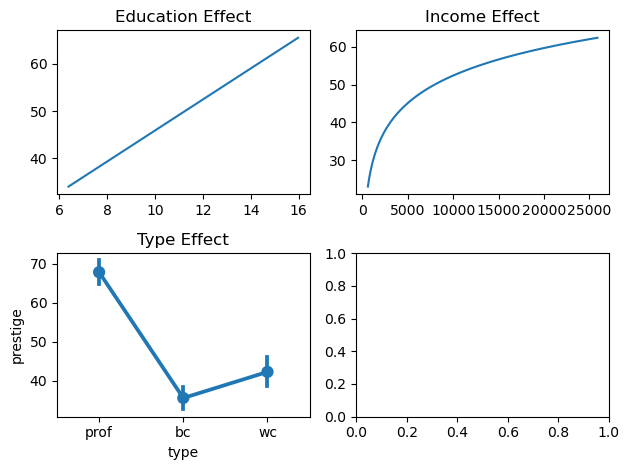

In [27]:
# Fitting the model
prestige_mod1 = smf.ols('prestige ~ education + np.log2(income) + type', data=prestige).fit()
pres_b1,pres_b2,pres_b3,pres_b4,pres_b5 = prestige_mod1.params # store estimates
print(prestige_mod1.summary())

# Based on the output we an see that the baseline group is type = bc
# Therefore, the coefficients of T.prof and T.wc represent the difference in intercepts 
# (which are the same as the differences in means, though only in this case) between bc 
# and prof, and bc and wc respectively.

# Values spanning "education", "income", and "women" for plotting
prestige_range_educ = np.linspace(prestige['education'].min(), prestige['education'].max(), 200)
prestige_range_inc = np.logspace(np.log2(prestige['income'].min()), np.log2(prestige['income'].max()), 200, base=2)
prestige_range_women = np.linspace(prestige['women'].min(), prestige['women'].max(), 200)

# Average intercept (includes factors)
pres_avg_intercept = pres_b1 + pres_b2*avg_prof + pres_b3*avg_wc

# Effects plots
fig7, ax7 = plt.subplots(2, 2)
ax7[0,0].plot(prestige_range_educ, pres_avg_intercept + pres_b4*prestige_range_educ + pres_b5*np.log2(avg_income))
ax7[0,0].set_title('Education Effect')
ax7[0,1].plot(prestige_range_inc, pres_avg_intercept + pres_b4*avg_educ + pres_b5*np.log2(prestige_range_inc))
ax7[0,1].set_title('Income Effect')
sns.pointplot(prestige, x='type', y='prestige', ax=ax7[1,0])
ax7[1,0].set_title('Type Effect')
plt.tight_layout()

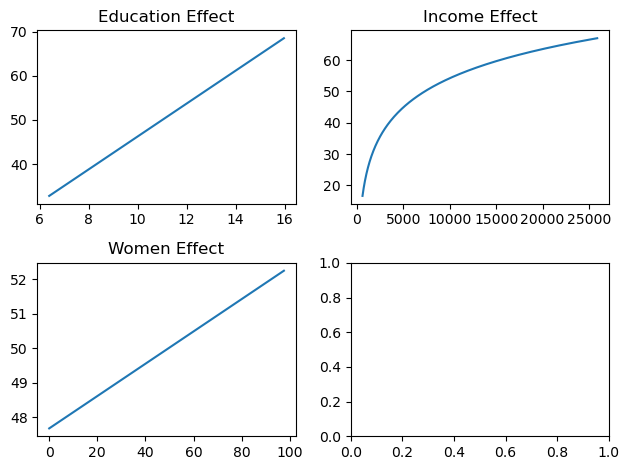

In [28]:
# We can also look at a different regression model that includes the percentage of women in the occupation

# Fit model
prestige_mod2 = smf.ols('prestige ~ education + np.log2(income) + women', prestige).fit()
pres_b1,pres_b2,pres_b3,pres_b4 = prestige_mod2.params # save estimates

# Effects plots
fig8, ax8 = plt.subplots(2, 2)
ax8[0,0].plot(prestige_range_educ, pres_b1 + pres_b2*prestige_range_educ + pres_b3*np.log2(avg_income) + pres_b4*avg_women)
ax8[0,0].set_title('Education Effect')
ax8[0,1].plot(prestige_range_inc, pres_b1 + pres_b2*avg_educ + pres_b3*np.log2(prestige_range_inc) + pres_b4*avg_women)
ax8[0,1].set_title('Income Effect')
ax8[1,0].plot(prestige_range_women, pres_b1 + pres_b2*avg_educ + pres_b3*np.log2(avg_income) + pres_b4*prestige_range_women)
ax8[1,0].set_title('Women Effect')
plt.tight_layout()

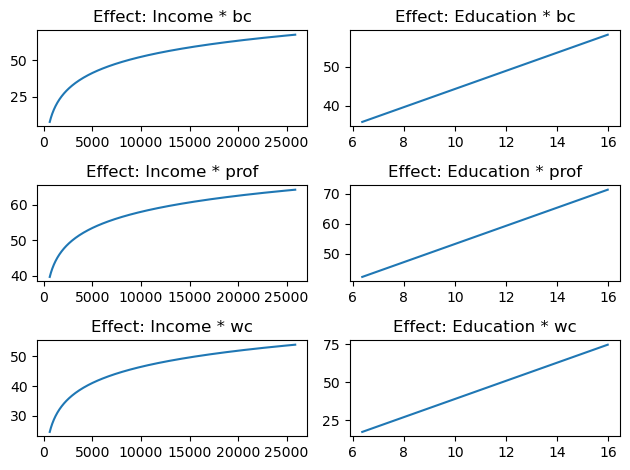

In [29]:
# Let's add interaction terms...
### Note: In the next section we will discuss interaction terms, here we'll just plot them
### Note: This is all much easier to do in R

# Fit model
prestige_mod3 = smf.ols('prestige ~ education + np.log2(income) + type + np.log2(income):type + education:type',
                        data=prestige).fit()
pres_m3 = prestige_mod3.params # store parameters

# Compute effects: income
## type = bc
pres_inc_bc = pres_m3['Intercept'] + pres_m3['education']*avg_educ + pres_m3['np.log2(income)']*np.log2(prestige_range_inc)

## type = prof
pres_inc_prof = (pres_inc_bc + pres_m3['type[T.prof]'] + pres_m3['education:type[T.prof]']*avg_educ
                 + pres_m3['np.log2(income):type[T.prof]']*np.log2(prestige_range_inc))

## type = wc
pres_inc_wc = (pres_inc_bc + pres_m3['type[T.wc]'] + pres_m3['education:type[T.wc]']*avg_educ
                 + pres_m3['np.log2(income):type[T.wc]']*np.log2(prestige_range_inc))

# Compute effects: education
## type = bc
pres_edu_bc = pres_m3['Intercept'] + pres_m3['education']*prestige_range_educ + pres_m3['np.log2(income)']*np.log2(avg_income)

## type = prof
pres_edu_prof = (pres_edu_bc + pres_m3['type[T.prof]'] + pres_m3['education:type[T.prof]']*prestige_range_educ
                 + pres_m3['np.log2(income):type[T.prof]']*np.log2(avg_income))

## type = wc
pres_edu_wc = (pres_edu_bc + pres_m3['type[T.wc]'] + pres_m3['education:type[T.wc]']*prestige_range_educ
               + pres_m3['np.log2(income):type[T.wc]']*np.log2(avg_income))

# Effects plots
fig9, ax9 = plt.subplots(3, 2)
ax9[0,0].plot(prestige_range_inc, pres_inc_bc)
ax9[0,0].set_title('Effect: Income * bc')
ax9[1,0].plot(prestige_range_inc, pres_inc_prof)
ax9[1,0].set_title('Effect: Income * prof')
ax9[2,0].plot(prestige_range_inc, pres_inc_wc)
ax9[2,0].set_title('Effect: Income * wc')
ax9[0,1].plot(prestige_range_educ, pres_edu_bc)
ax9[0,1].set_title('Effect: Education * bc')
ax9[1,1].plot(prestige_range_educ, pres_edu_prof)
ax9[1,1].set_title('Effect: Education * prof')
ax9[2,1].plot(prestige_range_educ, pres_edu_wc)
ax9[2,1].set_title('Effect: Education * wc')
plt.tight_layout()


lattice theme set by effectsTheme()
See ?effectsTheme for details.


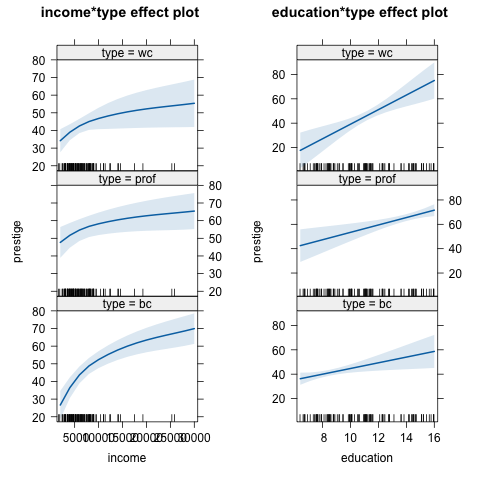

In [30]:
%%R
# Repeat of above, but in R

library(car)
library(effects)

# Fit model, produce effect plots
prestige_mod3 = lm(prestige ~ education + log2(income) + type + log2(income):type + education:type, data = Prestige)
plot(allEffects(prestige_mod3),layout=c(1,3))

In [31]:
# We can include one more interaction term

prestige_mod4 = smf.ols('prestige ~ education + np.log2(income) + education:type + np.log2(income):type',
                        data=prestige).fit()
pres_m4 = prestige_mod4.params # store estimates

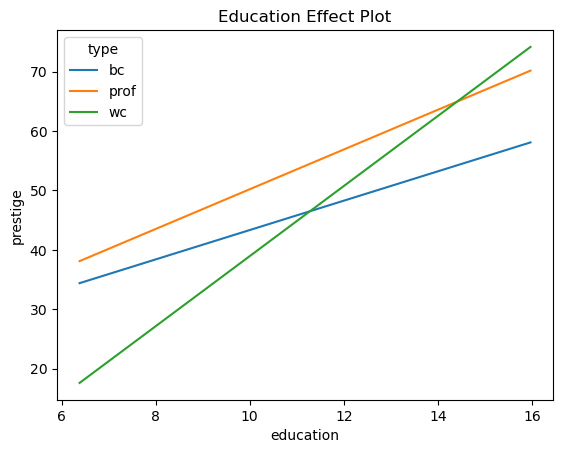

In [32]:
# First: education effects

# Compute effects
pres_m4_educ = pd.DataFrame({
    'education':prestige_range_educ,
    'bc':pres_m4['Intercept'] + pres_m4['education']*prestige_range_educ + pres_m4['np.log2(income)']*np.log2(avg_income)
})
pres_m4_educ['prof'] = pres_m4_educ['bc'] + pres_m4['education:type[T.prof]']*prestige_range_educ + pres_m4['np.log2(income):type[T.prof]']*np.log2(avg_income)
pres_m4_educ['wc'] = pres_m4_educ['bc'] + pres_m4['education:type[T.wc]']*prestige_range_educ + pres_m4['np.log2(income):type[T.wc]']*np.log2(avg_income)

# Pivot data from wide to long
prestige_mod4_education = pres_m4_educ.melt(id_vars='education', value_vars=['bc', 'prof', 'wc'], var_name='type', value_name='prestige')

# Plot
sns.lineplot(prestige_mod4_education, x='education', y='prestige', hue='type')
plt.title('Education Effect Plot')
plt.show()

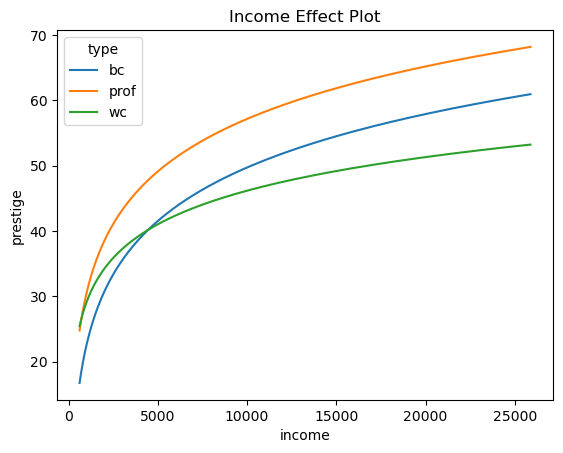

In [33]:
# Second: income effects

# Compute effects
pres_m4_inc = pd.DataFrame({
    'income':prestige_range_inc,
    'bc':pres_m4['Intercept'] + pres_m4['education']*avg_educ + pres_m4['np.log2(income)']*np.log2(prestige_range_inc)
})
pres_m4_inc['prof'] = pres_m4_inc['bc'] + pres_m4['education:type[T.prof]']*avg_educ + pres_m4['np.log2(income):type[T.prof]']*np.log2(prestige_range_inc)
pres_m4_inc['wc'] = pres_m4_inc['bc'] + pres_m4['education:type[T.wc]']*avg_educ + pres_m4['np.log2(income):type[T.wc]']*np.log2(prestige_range_inc)

# Pivot data from wide to long
prestige_mod4_income = pres_m4_inc.melt(id_vars='income', value_vars=['bc', 'prof', 'wc'], var_name='type', value_name='prestige')

# Plot
sns.lineplot(prestige_mod4_income, x='income', y='prestige', hue='type')
plt.title('Income Effect Plot')
plt.show()

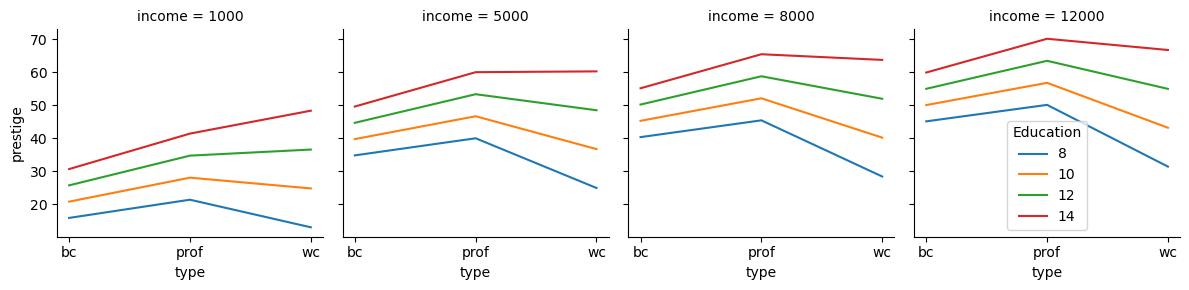

In [34]:
# Third: type effects

# Compute effects
pres_m4_type = pd.DataFrame({
    'income':np.repeat([8000, 12000, 1000, 5000], repeats=4),
    'education':np.tile([8, 12, 10, 14], reps=4)
})
pres_m4_type_bc = []
pres_m4_type_prof = []
pres_m4_type_wc = []
for l in range(16):
    inc,educ = pres_m4_type.iloc[l]
    pres_m4_type_bc.append(pres_m4['Intercept'] + pres_m4['education']*educ + pres_m4['np.log2(income)']*np.log2(inc))
    pres_m4_type_prof.append(pres_m4_type_bc[l] + pres_m4['education:type[T.prof]']*educ + pres_m4['np.log2(income):type[T.prof]']*np.log2(inc))
    pres_m4_type_wc.append(pres_m4_type_bc[l] + pres_m4['education:type[T.wc]']*educ + pres_m4['np.log2(income):type[T.wc]']*np.log2(inc))

# Combine
pres_m4_type['bc'] = pres_m4_type_bc; pres_m4_type['prof'] = pres_m4_type_prof; pres_m4_type['wc'] = pres_m4_type_wc

# Pivot data from wide to long
prestige_mod4_type = pres_m4_type.melt(id_vars=['income', 'education'], value_vars=['bc', 'prof', 'wc'], var_name='type', value_name='prestige')

# Plot
facet = sns.FacetGrid(data=prestige_mod4_type,hue='education',col='income')
facet.map_dataframe(sns.lineplot, x="type", y='prestige')
plt.legend(title='Education')
plt.tight_layout()

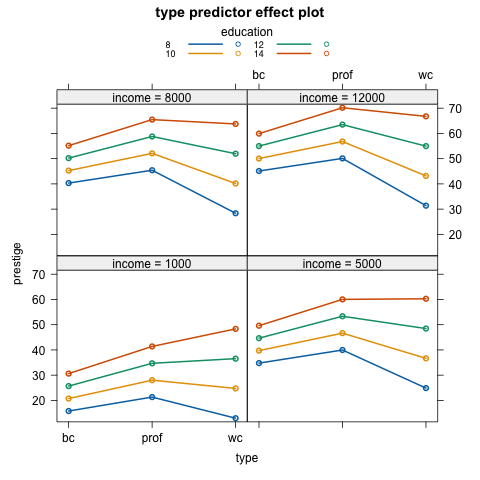

In [35]:
%%R

# The above code was used to replicate the following in R:

# Model
prestige_mod4 <- lm(prestige ~ education + log2(income) + education:type + log2(income):type, data = Prestige)

# Computing & graphing effects
prestige_mod4_pEff <- predictorEffects(prestige_mod4,
                                       xlevels=list(income = c(1000, 5000, 8000, 12000), education = c(8, 10, 12, 14))
                                       )
plot(prestige_mod4_pEff,lines=list(multiline=TRUE), selection="type")

An interaction effect between two predictors is represented by the product of the two variables (we can have more than two). For example, if one of the variables is factor (=$D$) and the other variable is quantitative (e.g., $PRICE$), then $D\times PRICE$ is called a *slope interaction (or indicator) variable* because its  effect is to change the slope of the regression line. We can revisit the `utown` data set from example 5 (Home Prices vs. Location) but instead introduce an interaction term between location and area. Effectively we are capturing the influence that one predictor has on the other. 

$$
E(PRICE) = \beta_1 + \beta_2 SQFT + \gamma (SQFT \times D)=
\begin{cases}
\beta_1 + (\beta_2 + \gamma) SQFT &\text{when}\phantom{.}D=1\\
\beta_1 + \beta_2 SQFT &\text{when}\phantom{.}D=0
\end{cases}
$$

The figure below illustrates this case.

<img src="images/L2_fig3.png" alt="Slope interaction" width="600">

In [36]:
# Example 8: Slope interaction, with 'utown' data set
### Model: Home Prices (y=price) vs. Area (x1=sqft) * Location (D=utown)

utown_mod2 = smf.ols('price ~ sqft + sqft:utown', data=utown).fit()
print(utown_mod2.summary())
# Note that the slope has changed from 8.36 (w/o the interaction term) to a higher value of (7.07 + 2.38 = 9.45)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     3205.
Date:                Wed, 16 Oct 2024   Prob (F-statistic):               0.00
Time:                        08:41:31   Log-Likelihood:                -4157.9
No. Observations:                1000   AIC:                             8322.
Df Residuals:                     997   BIC:                             8337.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     38.1775      4.264      8.953      0.0

utown	 effect
0.0 	 216.4251
0.2 	 228.4288
0.5 	 246.4343
0.8 	 264.4398
1.0 	 276.4435


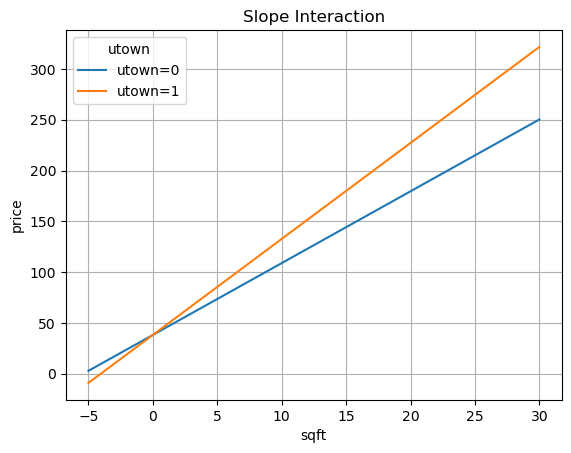

In [37]:
# Let's look at some marginal effects

# Mean level when utown = 0
utown_mod2_utown0 = utown_mod2.params['Intercept'] + utown_mod2.params['sqft']*utown['sqft'].mean()

# Print effect of utown level
print('utown\t effect')
for p in np.array([0, 0.2, 0.5, 0.8, 1.]):
    print(f'{p} \t {utown_mod2_utown0 + utown_mod2.params["sqft:utown"] * p * utown["sqft"].mean():.4f}')

# Plot effect
utown_span_sqft = np.linspace(-5, 30, 200)
utown_mod2_df = pd.DataFrame({
    'sqft':utown_span_sqft,
    'utown=0': utown_mod2.params['Intercept'] + utown_mod2.params['sqft']*utown_span_sqft,
    'utown=1': utown_mod2.params['Intercept'] + (utown_mod2.params['sqft'] + utown_mod2.params["sqft:utown"])*utown_span_sqft
}).melt(id_vars='sqft', value_vars=['utown=0', 'utown=1'], var_name='utown', value_name='price')

plt.grid()
sns.lineplot(utown_mod2_df, x='sqft', y='price', hue='utown')
plt.title('Slope Interaction')
plt.show()

Another possibility is that we have both intercept and slope interaction variables.

$$E(PRICE)  = \beta_1 +  \delta D + \beta_2 SQFT + \gamma (SQFT \times D)=
\begin{cases}
(\beta_1 + \delta) + (\beta_2 + \gamma) SQFT & \text{when} \phantom{.}D=1 \\
\beta_1 + \beta_2 SQFT & \text{when} \phantom{.}D=0.
\end{cases}$$

The figure below illustrates this case.

<img src="images/L2_fig4.png" alt="Intercept and slope interaction" width="600">

In [38]:
# Example 9: Intercept & slope interaction, with 'utown' data set
### Model: Home Prices (y=price) vs. Area (x1=sqft) * Location (D=utown)

utown_mod3 = smf.ols('price ~ sqft*utown', data=utown).fit() # equivalent: utown + sqft + sqft:utown
print(utown_mod3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     2162.
Date:                Wed, 16 Oct 2024   Prob (F-statistic):               0.00
Time:                        08:41:31   Log-Likelihood:                -4152.5
No. Observations:                1000   AIC:                             8313.
Df Residuals:                     996   BIC:                             8333.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.0625      6.239      3.696      0.0

Interactions between quantitative variables are very common in economics, and exemplify how the effect of one variable influences the other. For example, consider a model for pizza expenditure as a function of income and age, with an interaction variable for age and income as follows:

$$
PIZZA = \beta_1 + \beta_2 AGE + \beta_3 INCOME + \beta_4 (AGE \times INCOME) +e.
$$

In [39]:
# Example 10: Interactions between Quantitative variables
### Model:  Pizza Expenditure (y=pizza) vs. Age(x1=age) and Income(x2=income)

pizza = pd.read_csv('data/pizza.csv')
pizza_mod = smf.ols('pizza ~ age * income', data=pizza).fit()
print(pizza_mod.summary())

# Let's compute the marginal effect of age on pizza expenditure at two levels of income: $25k & $90k
DpizzaDage = pizza_mod.params['age'] + pizza_mod.params['age:income'] * np.array([25, 90])
print('\n\nMarginal effects:\n', DpizzaDage)

# This suggests that the marginal effect of age is a decrease in annual spending 
# of $6.05 for an income of $25, and $14.07 for an income of $90k.

                            OLS Regression Results                            
Dep. Variable:                  pizza   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     7.586
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           0.000468
Time:                        08:41:31   Log-Likelihood:                -248.42
No. Observations:                  40   AIC:                             504.8
Df Residuals:                      36   BIC:                             511.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    161.4654    120.663      1.338      0.1

Lastly, we will consider another popular type of model in econometrics---one that includes interactions between factor variables. As an illustration we will consider a model for hourly wages as a function of years of education, race and gender. 

$$WAGE =  \beta_1 + \beta_2 EDUC + \delta_1 BLACK + \delta_2 FEMALE + \gamma(BLACK \times FEMALE) +e.$$

The indicator variable `FEMALE`=1 (person is a female), and `BLACK`= 1(person is black). In this case we have four models to consider:

$$
E(WAGE)  =
\begin{cases}
\beta_1 + \beta_2 EDUC  & WHITE-MALE\\
(\beta_1 + \delta_1) + \beta_2 EDUC & BLACK-MALE\\
(\beta_1 + \delta_2) + \beta_2 EDUC & WHITE-FEMALE\\
(\beta_1 + \delta_1 + \delta_2 + \gamma) + \beta_2 EDUC & BLACK-FEMALE.
\end{cases}
$$

Given the four models above, we can see that the baseline (reference or control) group (`BLACK` = 0 and `FEMALE` = 0) would be WHITE-MALE.

The table below shows the estimates of the model:

<img src="images/L2_fig5.png" alt="Factor interaction model estimates" width="800">

In [40]:
# Example 11: Interactions between Factors
### Model: Wages (y=wage) vs. Education (x1=educ), Race (x2=black), and Gender (x3=female)

cps = pd.read_csv('data/cps4_small.csv')
cps_mod = smf.ols('wage ~ educ + black * female', data=cps).fit()
cps_m_b1,cps_m_b2,cps_m_b3,cps_m_b4,cps_m_b5 = cps_mod.params # store parameter estimates

print(cps_mod.summary())

# From the output, we can provide a couple of interpretations by comparing different groups:

# (1) WHITE-MALE vs. WHITE-FEMALE: = delta_2 = -$4.78
#       Other things being equal, we expect white males to earn $4.78/hr more than white females.

# (2) WHITE-MALE vs. BLACK-FEMALE: = (delta_1 + delta_2 + gamma) = -4.1691 -4.7846 + 3.8443 = -$5.11
#       Other things being equal, we expect white males to earn $5.11/hr more than black females.

# (3) WHITE-FEMALE vs. BLACK-FEMALE: delta_1 + gamma = -$0.3248.
#       Other things being equal, we expect white females to earn $0.3248/hr more than black females.

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     65.67
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           2.53e-49
Time:                        08:41:31   Log-Likelihood:                -3853.5
No. Observations:                1000   AIC:                             7717.
Df Residuals:                     995   BIC:                             7741.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -5.2812      1.900     -2.779   

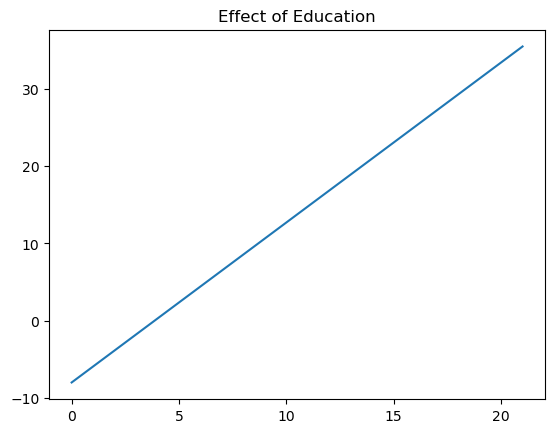

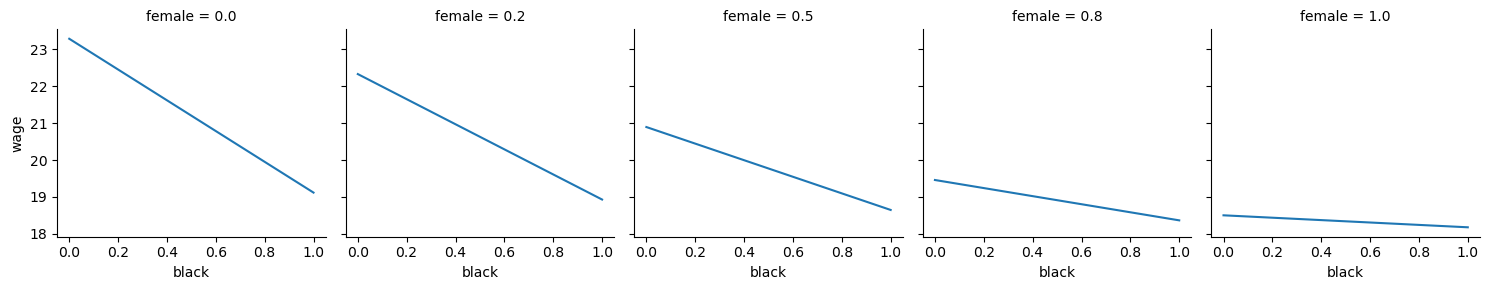

In [41]:
# Let's take a quick look at the marginal effects

cps_span_educ = np.linspace(cps['educ'].min(), cps['educ'].max(), 200)
cps_m_educ_eff = (cps_m_b1 + cps_m_b2*cps_span_educ                                 # baseline
                  + cps_m_b3*cps['black'].mean() + cps_m_b4*cps['female'].mean()    # black-male, white-female
                  + cps_m_b5*cps['black'].mean()*cps['female'].mean())              # black-female

# Plot education effect
plt.plot(cps_span_educ, cps_m_educ_eff)
plt.title('Effect of Education')
plt.show()

# Compute indicator variable effects
cps_m_baseline = cps_m_b1 + cps_m_b2*cps['educ'].mean()
cps_span_female = [0., 0.2, 0.5, 0.8, 1.]; cps_span_black = [0., 0.2, 0.5, 0.8, 1.]
cps_m_indicator_df = pd.DataFrame({'black':cps_span_black})

for w in cps_span_female:
    w_list = []
    for b in cps_span_black:
        w_list.append(cps_m_baseline + cps_m_b3*b + cps_m_b4*w + cps_m_b5*b*w)
    cps_m_indicator_df[f'{w}'] = w_list

# Pivot wide to long for plotting
cps_m_indicator_eff = cps_m_indicator_df.melt(id_vars='black', var_name='female', value_name='wage')

# Plot indicator variable effects 
facet2 = sns.FacetGrid(data=cps_m_indicator_eff,col='female')
facet2.map_dataframe(sns.lineplot, x="black", y='wage')
plt.tight_layout()

In [42]:
# We can also test directly the joint hypothesis that that neither race nor gender affects wage:
# H0: delta_1 = 0, delta_2 = 0, gamma = 0 against that at least one of them is different from 0.

# Joint hypothesis, rather than simple hypothesis (one constraint)
cps_h0 = np.array([[0, 0, 1, 0, 0],     # delta_1 = 0
                   [0, 0, 0, 1, 0],     # delta_2 = 0
                   [0, 0, 0, 0, 1]])    # delta_3 = 0
print(cps_mod.f_test(cps_h0))
# With p < 0.05, reject H0

# Note: The test-statistic is F = [(SSE_R -SSE_U)/J] / [SSE_U/(N-K)] where
# R =restricted, U = un-restricted, J = # of restrictions, N = # of observations, K = # of parameters

# N = 1000, K = 5, J =3. SSE_R = 135771, SSE_U = 130195
# The Restricted model is (WAGE = beta_1 + beta_2 EDUC) and
# the Unrestricted model is the original one with all the predictors.

<F test: F=14.20588254659794, p=4.5309699596472955e-09, df_denom=995, df_num=3>


In many applications we may need to include factor variables with more than 2 levels. For example, suppose we were interested in estimating the previous model but based on regional differences by comparing wages between the Northeast, Midwest, West, and South of the country. Our dummy variable (`D`) would then take on 4 values. We can easily incorporate this into our model by adding 3 factor variables as follows:

$$
WAGE = \beta_1 + \beta_2 EDUC + \delta_1 SOUTH + \delta_2 MIDWEST + \delta_3 WEST + e.
$$

Notice that we omitted a variable for the Northeast region. This is to avoid the *Dummy Variable Trap*. Basically, we only need $N-1$ dummy variables for the $N$ levels. In this case, the Northeast would be our baseline group.

$$
E(WAGE)=
\begin{cases}
(\beta_1+\delta_3)+\beta_2EDUC & WEST \\
(\beta_1+\delta_2)+\beta_2EDUC & MIDWEST \\
(\beta_1+\delta_1)+\beta_2EDUC & SOUTH \\
\beta_1+\beta_2EDUC & NORTHEAST
\end{cases}
$$

In [43]:
# Example 12: Interactions between Factors (with more than two levels)
### Model: Wages (y=wage) vs. Education (x1=educ), Race (x2=black), Gender (x3=female), Location (Northeast, South, West, Midwest)

# For simplicity, assume we are interested in comparing regional wage differences
# between the South and the rest of the country.
cps_mod2 = smf.ols('wage ~ educ + south + midwest + west + black*female', cps).fit()
print(cps_mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     39.71
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           2.32e-49
Time:                        08:41:32   Log-Likelihood:                -3847.1
No. Observations:                1000   AIC:                             7710.
Df Residuals:                     992   BIC:                             7749.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.8062      2.029     -2.369   

The regression results suggest that maybe the wages differences between e.g., the South and the rest of the country are not statistically significant. We can perform a *Chow Test* to see if the two regressions are the same or not. The null hypothesis is that they are the same. If they are, we may want to consider pooling the data together. We can write the model as:

\begin{align*}
WAGE =\ &\beta_1 + \beta_2 EDUC +\delta_1 BLACK + \delta_2 FEMALE + \gamma (BLACK \times FEMALE) \\
&+ \theta_1 SOUTH + \theta_2 (EDUC \times SOUTH) + \theta_3 (BLACK \times SOUTH) \\
&+ \theta_4 (FEMALE\times SOUTH) + \theta_5 (BLACK \times FEMALE \times SOUTH) + e
\end{align*}

In this case the null hypothesis can be written as: $H_0: \theta_1=0, \theta_2=0, \theta_3=0, \theta_4=0,     \theta_5=0$ against $H_1: \theta_i \neq 0$, for any $i$.

In [44]:
# Example 13: Interactions between Factors (with more than two levels)
### Model: Wages (y=wage) vs. Education (x1=educ), Race (x2=black), Gender (x3=female), Location (South)

# Full model
cps_mod3 = smf.ols('wage ~ educ + black * female + south/(educ + black * female)', data=cps).fit()
print(cps_mod3.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     29.26
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           2.00e-45
Time:                        08:41:32   Log-Likelihood:                -3852.6
No. Observations:                1000   AIC:                             7725.
Df Residuals:                     990   BIC:                             7774.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -6.6056      2

In [45]:
# Note: We can estimate the two regression models separately, and then compare them using the Chow Test:

# Subsetted models
cps_south = cps.loc[cps['south'] == 1]
cps_nosouth = cps.loc[cps['south'] == 0]
cps_mod3_south = smf.ols('wage ~ educ + black * female', data=cps_south).fit()
cps_mod3_nosouth = smf.ols('wage ~ educ + black * female', data=cps_nosouth).fit()

# Print model summaries
info_dict = {'Observations' : lambda x: f'{int(x.nobs)}',
             'R^2' : lambda x: f'{x.rsquared:.3f}',
             'Adjusted R^2' : lambda x: f'{x.rsquared_adj:.3f}',
             'Residual Std. Error' : lambda x: f'{np.sqrt(x.mse_resid):.3f}',
             'F Statistic' : lambda x: f'{x.fvalue:.3f}'}
cps_mod3_results = summary_col([cps_mod3, cps_mod3_south, cps_mod3_nosouth],
                               float_format='%0.2f',
                               stars = True,
                               info_dict=info_dict,
                               model_names=['Full',
                                            'South',
                                            'No South'])
print(cps_mod3_results)


                      Full    South   No South
----------------------------------------------
Intercept           -6.61*** -2.66    -6.61***
                    (2.34)   (3.42)   (2.30)  
R-squared           0.21     0.18     0.22    
R-squared Adj.      0.20     0.17     0.22    
black               -5.09*   -3.38    -5.09*  
                    (2.64)   (2.58)   (2.60)  
black:female        5.31     2.37     5.31    
                    (3.50)   (3.38)   (3.45)  
educ                2.17***  1.86***  2.17*** 
                    (0.17)   (0.24)   (0.16)  
female              -5.01*** -4.10*** -5.01***
                    (0.90)   (1.58)   (0.89)  
south               3.94                      
                    (4.05)                    
south:black         1.70                      
                    (3.63)                    
south:black:female  -2.94                     
                    (4.79)                    
south:educ          -0.31                     
            

In [46]:
# Then the chow test

# Our hypotheses
cps_m3_h0 = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],     # south = 0
                      [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],     # educ:south = 0
                      [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],     # black:south = 0
                      [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],     # female:south = 0
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])    # black:female:south = 0
print(cps_mod3.f_test(cps_m3_h0))

# With p > 0.05, fail to reject H0
# We conclude that there do not appear to be statistically significant differences
# between wages in the south and the rest of the country.

<F test: F=0.3202778623332821, p=0.9009446557490868, df_denom=990, df_num=5>


# <font face="garamond" size="14" color="#122DAC">2. Boostrapping Regression Models</font>

In general, for any regression model estimated, it is a good idea to also include bootstrap estimates as way to test for the robustness of the estimates. The core principle being simple random sampling with replacement from the original dataset, and for each sample estimating the same regression model and then collecting the usual statistics.

In [47]:
# Example 15: Bank Transaction Time as a function of two types of transactions' times

transact = pd.read_csv('data/transact.csv')
transact.head()

transact_Y = transact['time']
transact_X = transact[['t1', 't2']]

In [48]:
# Sample data
random.seed(90095)

# Function to fit model and output parameters
def fitted_OLS(x, y):
    # Here we'll use another way to fit an OLS model
    X = sm.add_constant(x)
    model = sm.OLS(endog=y, exog=X)
    fitted = model.fit()

    return fitted

# Run bootstrap
n_iterations = 1000
bootstrap_results = np.zeros((n_iterations, 4))
bootstrap_sigma = []

for p in range(n_iterations):
    X_resampled, y_resampled = resample(transact_X, transact_Y)
    fitted = fitted_OLS(x=X_resampled, y=y_resampled)
    coefs = fitted.params
    sigma_hat = pd.Series(np.sqrt(fitted.mse_resid))
    bootstrap_results[p:] = pd.concat([coefs, sigma_hat]) # includes bootstrapped sigma hat


transact_bs = pd.DataFrame(bootstrap_results, columns=['intercept','t1', 't2', 'sigmaHat'])

# Summary statistics
transact_bs_summary = transact_bs.agg(['mean', 'std', 'median'], axis=0).T
transact_bs_summary['lower-95'] = transact_bs.apply(lambda x: np.quantile(x,0.025)) # 2.5% lower bound
transact_bs_summary['upper-95'] = transact_bs.apply(lambda x: np.quantile(x,0.975)) # 97.5% upper bound

transact_bs_summary

,mean,std,median,lower-95,upper-95
intercept,159.812178,188.824288,161.525381,-199.885452,531.586225
t1,5.493597,0.688053,5.499697,4.119814,6.798540
t2,2.022397,0.150975,2.019063,1.744337,2.320382
sigmaHat,1126.065489,89.117195,1126.205363,945.626232,1295.528742


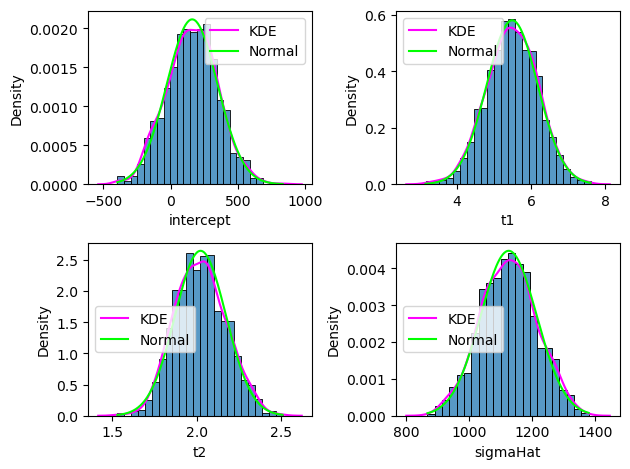

In [49]:
# Plotting bootstrapped estimates
fig10, ax10 = plt.subplots(2, 2)

for s in range(4):
    transact_variable = transact_bs_summary.iloc[s]
    estimate_name = transact_bs.columns[s]
    estimate_range = np.linspace(min(transact_bs[estimate_name]), max(transact_bs[estimate_name]), 200)
    sns.histplot(transact_bs[estimate_name], stat='density', kde=False, ax=ax10[s // 2, s % 2])
    sns.kdeplot(transact_bs[estimate_name], color='fuchsia', ax=ax10[s // 2, s % 2], label='KDE')
    sns.lineplot(x=estimate_range, y=norm.pdf(estimate_range, transact_variable['mean'], transact_variable['std']),
                 color='lime',ax=ax10[s // 2, s % 2], label='Normal')
plt.tight_layout()
plt.show()

# <font face="garamond" size="14" color="#122DAC">3. Modeling Issues in Linear Regression</font>

## 3.1 Predictor Transformations

Suppose we have a linear model $y = \beta_1 + \beta_2 x_2 + \beta_3 x_3+e$, but are interested in the relationship between $y$ and $x_3$ only. Therefore, we would like to plot $y$ vs. $x_3$ but with the effect of $x_2$ removed. This is equivalent to plotting $y - \beta_1 - \beta_2 x_2$ vs. $x_3$. We can accomplish this with a *Component-Plus-Residual* Plot. Mathematically, we are really doing an approximation by estimating a partial residual for $x_3$. 
Algorithmically, here is how we can estimate it:
1. Obtain the coefficient estimates $\beta_k$, for $k=1, 2, 3$ from $E[y|x] = \beta_1 + \beta_2 x_2 + \beta_3 x_3$ and respective residuals, $e$
2. Estimate the partial residual ($e_{partial} $) according to: $e_{partial}  = y-\widehat{\beta}_{1} - \widehat{\beta}_2 x_2$
3. The Component-Plus-Residual is given by: $e_{partial} = \widehat{\beta}_3 x_3 + e$

In general, we can express the partial residual as $e_{partial,ij} = e_i + b_j x_{ij}$. This plot is often used to help detect the need for transformations of the predictor variables by looking for any departures from linearity in the plots of $e_{partial,ij}$ vs. $x_{ij}$. If we identify any nonlinear dynamics, we can then apply the techniques from Lecture 1 to the respective predictor variables.

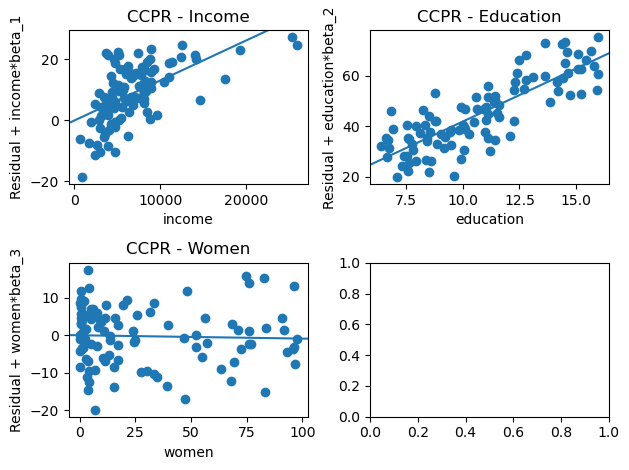

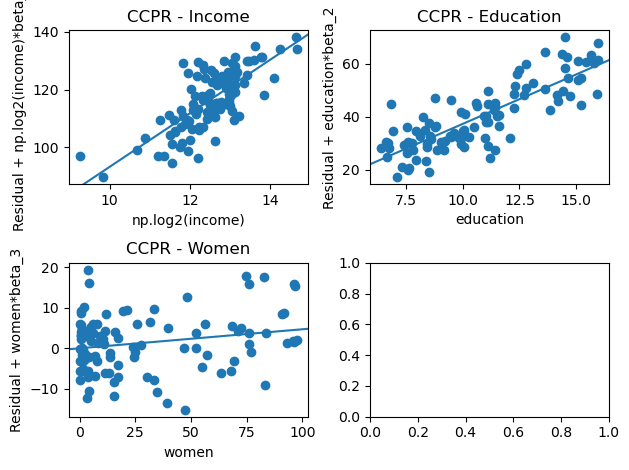

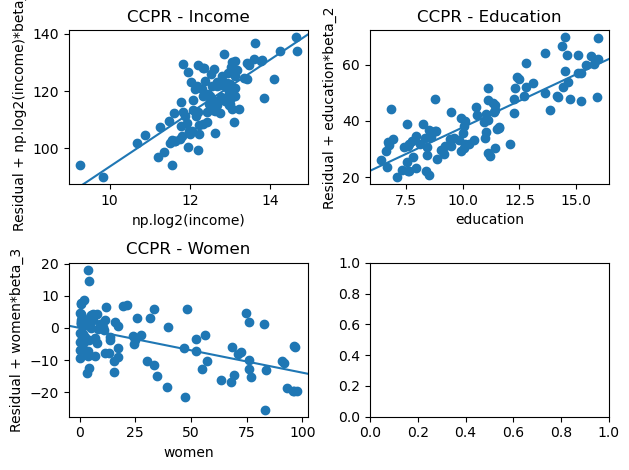

In [50]:
# Example 16: Component-Plus-Residual Plot
# Using 'prestige' dataset

prestige_mod5 = smf.ols('prestige ~ income + education + women', data=prestige).fit()


fig11, ax11 = plt.subplots(2, 2)
sm.graphics.plot_ccpr(prestige_mod5, 'income', ax=ax11[0,0])
ax11[0,0].set_title('CCPR - Income')
sm.graphics.plot_ccpr(prestige_mod5, 'education', ax=ax11[0,1])
ax11[0,1].set_title('CCPR - Education')
sm.graphics.plot_ccpr(prestige_mod5, 'women', ax=ax11[1,0])
ax11[1,0].set_title('CCPR - Women')
plt.tight_layout()
plt.show()

# The dashed blue line is a partial fit. Of the 3 predictors, income
# seems have the largest degree of curvature. Therefore, we might consider
# transforming it using, e.g., the bulging rule. 

# We can try applying a log transformation to income
prestige_mod6 = smf.ols('prestige ~ np.log2(income) + education + women', data=prestige).fit()

fig12, ax12 = plt.subplots(2, 2)
sm.graphics.plot_ccpr(prestige_mod6, 'np.log2(income)', ax=ax12[0,0])
ax12[0,0].set_title('CCPR - Income')
sm.graphics.plot_ccpr(prestige_mod6, 'education', ax=ax12[0,1])
ax12[0,1].set_title('CCPR - Education')
sm.graphics.plot_ccpr(prestige_mod6, 'women', ax=ax12[1,0])
ax12[1,0].set_title('CCPR - Women')
plt.tight_layout()
plt.show()

# It looks better, but maybe we should also apply a quadratic transformation to women
prestige_mod7 = smf.ols('prestige ~ np.log2(income) + education + women + I(women**2)', data=prestige).fit()

fig13, ax13 = plt.subplots(2, 2)
sm.graphics.plot_ccpr(prestige_mod7, 'np.log2(income)', ax=ax13[0,0])
ax13[0,0].set_title('CCPR - Income')
sm.graphics.plot_ccpr(prestige_mod7, 'education', ax=ax13[0,1])
ax13[0,1].set_title('CCPR - Education')
sm.graphics.plot_ccpr(prestige_mod7, 'women', ax=ax13[1,0])
ax13[1,0].set_title('CCPR - Women')
plt.tight_layout()
plt.show()

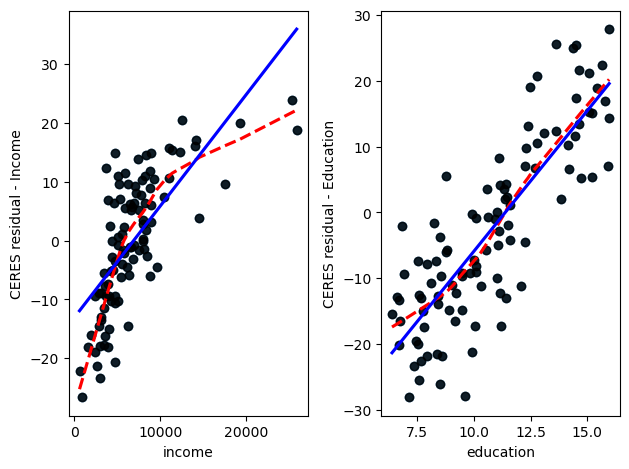

In [51]:
# Note: When there are strong non-linear relations between predictors, the
# component-plus-residual plots may not work, in this case, we instead look
# at CERES Plots (Combining conditional Expectations and REsiduals)

prestige_ceres = pd.DataFrame({
    'income':prestige['income'],
    'education':prestige['education'],
    'CERES residual - Income':regressionplots.ceres_resids(prestige_mod5, focus_exog='income'),
    'CERES residual - Education':regressionplots.ceres_resids(prestige_mod5, focus_exog='education')
})

fig14, ax14 = plt.subplots(1,2)
sns.regplot(data=prestige_ceres,x='income', y='CERES residual - Income', lowess=True, ax=ax14[0],
            line_kws={'color':'red', 'linestyle':'--'})
sns.regplot(data=prestige_ceres,x='income', y='CERES residual - Income', ci=None, ax=ax14[0],
            color='black', line_kws={'color':'blue'})
sns.regplot(data=prestige_ceres,x='education', y='CERES residual - Education', lowess=True, ax=ax14[1],
            line_kws={'color':'red', 'linestyle':'--'})
sns.regplot(data=prestige_ceres,x='education', y='CERES residual - Education', ci=None, ax=ax14[1],
            color='black', line_kws={'color':'blue'})
plt.tight_layout()

A more general method for dealing with nonlinear predictors is to a apply the *Box-Tidwell* method for transforming predictors. Their proposed model assumes the form:

$$
y =\beta_0 + \beta_1 TB_{BC}(x_1, \gamma_1)+ \cdots + \beta_k T_{BC}(x_k, \gamma_k) +\varepsilon,
$$

where $T_{BC}$ is the Box-Cox power transformation introduced in Lecture 1. Unfortunately there is not a simple implementation in Python, so we will use the `car` package in R.

In [52]:
%%R

library(car)

# Example 17: Box-Tidwell Transformation

# We can use the function boxTidwell, which suggests the appropriate transformation(s)
# via MLE, while also allowing for user specified transformations

# For example, let's apply a quadratic transformation to women and see what it
# recommends for income and education:

boxTidwell(prestige ~ income + education, other.x = ~poly(women,2), data=Prestige)

# According to the output: lambda = -0.04 for income--> log
# According to the output: lambda = 2.19 for education--> quadratic

# To visualize these results, we can plot the "Constructed-Variable Plots"
# 'construction' in this context means transformation

          MLE of lambda Score Statistic (t)  Pr(>|t|)    
income        -0.037775             -5.3013 7.459e-07 ***
education      2.192827              2.4056   0.01808 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

iterations =  12 

Score test for null hypothesis that all lambdas = 1:
F = 16.175, df = 2 and 95, Pr(>F) = 9.007e-07



## 3.2 Omitted Variable Bias

The *Omitted Variable Bias* quantifies the impact of omitting a relevant (e.g., statistically and/or economically significant) variable in a regression model. For example, suppose the model true underlying population model is $y = \beta_1 + \beta_2 x_2 + \beta_3 x_3 + e$ where both $x_2$ and $x_3$ should be included, but instead we only estimated the model $y = \beta_1 + \beta_2 x_2 +e$. How can we quantify the effect that omitting $x_3$ would have on the model? We can show that mathematically it corresponds to a bias, namely:

$$
bias(b_{2}^{*}) = E(b_2)^* - \beta_2 = \beta_3 \frac{\widehat{{\rm Cov}(x_2, x_3)}}{{\rm Var(x_2)}}
$$

The example below shows how omitting a relevant variable such as the wife's years of education contribution to annual family income, leads to a $\sim \$2000$ bias.

In [53]:
# Example 18: Omitted Variable Bias

edu_inc = pd.read_csv('data/edu_inc.csv')

# Correct model
edu_mod1 = smf.ols('faminc ~ he + we', data=edu_inc).fit()
print(edu_mod1.summary(), '\n\n')

                            OLS Regression Results                            
Dep. Variable:                 faminc   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     40.87
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           5.84e-17
Time:                        08:41:34   Log-Likelihood:                -5146.5
No. Observations:                 428   AIC:                         1.030e+04
Df Residuals:                     425   BIC:                         1.031e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5533.6288   1.12e+04     -0.493      0.6

In [54]:
# Incorrect Model
edu_mod2 = smf.ols('faminc ~ he', data=edu_inc).fit()
print(edu_mod2.summary())

# We can see that the effect of omitting wedu translates to an overstatement
# of ~$2000 which would correspond to the bias in this case.

                            OLS Regression Results                            
Dep. Variable:                 faminc   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     61.30
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           3.92e-14
Time:                        08:41:34   Log-Likelihood:                -5155.3
No. Observations:                 428   AIC:                         1.031e+04
Df Residuals:                     426   BIC:                         1.032e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.619e+04   8541.108      3.066      0.0

In [55]:
# Q: What if we include kl6 ( = number of children under the age of 6)?
edu_mod3 = smf.ols('faminc ~ he + we + kl6', data=edu_inc).fit()
print(edu_mod3.summary())

# A: In this case, the coefficients of hedu and wedu did not change by much,
# yet kl6 is both statistically and economically significant. 

# This suggests that the estimates of wedu and hedu are robust.

                            OLS Regression Results                            
Dep. Variable:                 faminc   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     30.43
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           7.77e-18
Time:                        08:41:34   Log-Likelihood:                -5142.4
No. Observations:                 428   AIC:                         1.029e+04
Df Residuals:                     424   BIC:                         1.031e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7755.3296   1.12e+04     -0.695      0.4

## 3.3 Irrelevant Variables

Typically, including extraneous variables in the model has the effect of increasing the variance of the other variables, and therefore, potentially rendering the respective coefficient estimates statistically insignificant.

In [56]:
# Example 19: Irrelevant Variables

# Full model
edu_mod3 = smf.ols('faminc ~ he + we + kl6', data=edu_inc).fit()

# The variables xtra_x5 and xtra_x6 are contain random values that are not associated with y
# We can would expect that the variances of the relevant variable will increase as we introduce
# these irrlevant variables.

# One irrelevant variable (xtra_x5)
edu_mod4 = smf.ols('faminc ~ he + we + kl6 + xtra_x5', data=edu_inc).fit()

# Two irrelevant variable (xtra_x5, xtra_x6)
edu_mod5 = smf.ols('faminc ~ he + we + kl6 + xtra_x5 + xtra_x6', data=edu_inc).fit()

# Model summaries
info_dict = {'Observations' : lambda x: f'{int(x.nobs)}',
             'R^2' : lambda x: f'{x.rsquared:.3f}',
             'Adjusted R^2' : lambda x: f'{x.rsquared_adj:.3f}',
             'Residual Std. Error' : lambda x: f'{np.sqrt(x.mse_resid):.3f}',
             'F Statistic' : lambda x: f'{x.fvalue:.3f}'}
edu_mod_compare = summary_col([edu_mod3, edu_mod4, edu_mod5],
                               float_format='%0.2f',
                               stars = True,
                               info_dict=info_dict,
                               model_names=['Full',
                                            '1 Extra',
                                            '2 Extra'])
print(edu_mod_compare)

# 'he', 'kl6', and 'we' show an increase in standard error


                        Full       1 Extra      2 Extra   
----------------------------------------------------------
Intercept           -7755.33     -7682.60     -7558.61    
                    (11162.93)   (11183.65)   (11195.41)  
R-squared           0.18         0.18         0.18        
R-squared Adj.      0.17         0.17         0.17        
he                  3211.53***   3377.22***   3339.79***  
                    (796.70)     (1247.06)    (1250.04)   
kl6                 -14310.92*** -14216.44*** -14200.18***
                    (5003.93)    (5039.39)    (5043.72)   
we                  4776.91***   4783.93***   5868.68**   
                    (1061.16)    (1063.16)    (2278.07)   
xtra_x5                          -180.16      888.84      
                                 (1042.33)    (2242.49)   
xtra_x6                                       -1067.19    
                                              (1981.69)   
Observations        428          428          428      

## 3.4 Multicollinearity

Multicollinearity occurs when there are strong linear relationships between the predictors. For example, consider the model $y= \beta_1 + \beta_2 x_2 + \beta_3 x_3 + e$, where $x_3 = \alpha_1 + \alpha_2 x_2$. In this case, Ordinary Least Squares cannot generate estimates of the regression coefficients because the predictor $x_2$ and $x_3$ move together. In this case (which is considered *Perfect Multicollinearity*) the solution would be to drop of the two predictors from the model.

In general, *Imperfect Multicollinearity* is more common. This occurs when, e.g., using the previous case, $x_3 = \alpha_1 + \alpha_2 x_2 + u$, where $u$ represents some unknown random component.

The effects of Multicollinearity can be summarized as follows:

1. The variances and standard errors of the regression coefficient estimates will increase. This is considered *variance inflation* and leads to lower $t$-statistics.
2. The overall fit of the regression equation will be largely unaffected by multicollinearity. Therefore, forecasting and prediction will be largely unaffected.
3. Regression coefficients can change substantially when variables are added or dropped.

### 3.4.1 Detecting Multicollinearity

There are several ways in which we can detect multicollinearity. Below are the 3 most common ones:

1. **Large Correlation Coefficients**

    High pairwise correlations among independent variables is a strong sign of multicollinearity. Usually $|r_{x_i,x_j}|\gtrsim 0.8$ is considered large.
2. **Large $R^2$ with Low $t$-Stats**

    It is possible for individual coefficients to be insignificant but for the overall fit of the equation to be high.
3. **Variance Inflation Factor (VIF)**

    VIF is a measure of how much the variance of the estimated regression coefficient $b_k$ is inflated by the existence of correlations among the predictor variables in the model. Consider for example $\widehat{var}(b_j)$ as given by: $$\widehat{var}(b_j) = \frac{\widehat{\sigma}^2}{(n-1)s^{2}_{j}}\times \frac{1}{1-R_{j}^{2}}.$$ The term $1/(1-R_{j}^{2})$ is called the *VIF*. Values of $\rm VIF=1$ suggest no correlation whereas $\rm VIF\gtrsim 10$ (and in some cases $\gtrsim 4$) is considered large, and thus, we might consider removing those variables with large VIFs from the model. The $R_{j}^{2}$ are obtained from the *Auxiliary Regressions*, i.e., $x_j$ regressed on the other predcitors.

An important limitation to of VIF is that it does not apply to nonlinear regressors or contrasts. For these cases we would instead use the *Generalized VIF (GVIF)* which is given by $GVIF^{1/(2p)}$, where $p$ represents the number of regressors in a term.

In [57]:
# Example 20: Multicollinearity (Fuel Efficiency)

# Load data and compute VIF
cars = pd.read_csv('data/cars2.csv')
cars_exog_vars = ['cyl', 'eng', 'wgt']
cars_exog = sm.add_constant(cars[cars_exog_vars]) # exogenous variables (predictors), with constant

print('---\t VIF')
for i,v in enumerate(cars_exog_vars):
    cars_vif = variance_inflation_factor(exog=cars_exog, exog_idx=i+1) # `exog_idx` is column index of predictor
    print(f'{v}\t {cars_vif:.5f}')

# We can see that both "cyl" and "eng" should be removed since VIF > 10

---	 VIF
cyl	 10.51551
eng	 15.78646
wgt	 7.78872


In [58]:
# Example 21: Multicollinearity (Median household value in Boston)

# Load data and compute VIF
boston = pd.read_csv('data/boston.csv')
boston_exog = boston.drop('medv', axis=1) # exogenous variables only
boston_exog_vars = boston_exog.columns
boston_exog = sm.add_constant(boston_exog)

boston_VIF = []
for i,v in enumerate(boston_exog_vars):
    boston_VIF.append(variance_inflation_factor(exog=boston_exog, exog_idx=i+1)) # `exog_idx` is col index of predictor

pd.DataFrame({
    'Variable':boston_exog_vars,
    'VIF':boston_VIF
}).sort_values(by='VIF')

# We can see that "nox", "rad", and "tax" might be worth removing since VIF > 4
# Also note that "indus" and "dis" are very close to 4, so we might want to consider removing them as well.

,Variable,VIF
3,chas,1.073995
11,black,1.348521
0,crim,1.792192
10,ptratio,1.799084
5,rm,1.933744
1,zn,2.298758
12,lstat,2.941491
6,age,3.100826
7,dis,3.955945
2,indus,3.991596


In [59]:
# Example 22: Multicollinearity (US Census Data)
### See Ericksen et. al., 1989

# Load data and compute VIF
ericksen = pd.read_csv('data/ericksen.csv', index_col=0)
ericksen['city'] = (ericksen['city'] == 'state').astype(int)
ericksen_exog = ericksen.drop('undercount', axis=1) # exogenous variables only
ericksen_exog_vars = ericksen_exog.columns
ericksen_exog = sm.add_constant(ericksen_exog)

ericksen_VIF = []
for i,v in enumerate(ericksen_exog_vars):
    ericksen_VIF.append(variance_inflation_factor(exog=ericksen_exog, exog_idx=i+1))

pd.DataFrame({
    'Variable':ericksen_exog_vars,
    'VIF':ericksen_VIF
}).sort_values(by='VIF')

# We can see that "minority", "poverty", and "high school" might be worth removing since VIF > 4

,Variable,VIF
3,language,1.635568
7,conventional,1.691320
5,housing,1.871745
1,crime,3.343586
6,city,3.537750
4,highschool,4.619169
2,poverty,4.625178
0,minority,5.009065


## 3.5 Model Misspecification: Ramsey RESET

As we have seen previously, sometimes adding nonlinear expressions for the predictors can help improve our model in terms of economic and statistical significance. A popular test to evaluate is such nonlinear terms are needed, is known as the *REgression Specification Error Test (RESET)*. For example, assume we have the model $y= \beta_1 + \beta_2 x_2 + \beta_3 x_3 + \varepsilon$ and we are interested in determining if we can improve the model by including higher order terms of the predictors. We can easily assess this by estimating the model $y= \beta_1 + \beta_2 x_2 + \beta_3 x_3 + \gamma \widehat{y}^2 + \varepsilon$, and testing the null hypothesis $H_0:\gamma =0$ against $H_0:\gamma \neq 0$. If we reject $H_0$, then we should consider including, e.g., quadratic terms or interaction terms. We can then perform the same test but instead including the term $\delta \widehat{y}^3$, and so on, until we fail to reject $H_0$. In practice, however, we should not have to include high order terms beyond 2 or 3.

In [60]:
# Example 23:  RESET (Generated Data)

# We will create 2 models--a quadratic and linear one--and test each for misspecification
random.seed(90095)

x = np.arange(1,31)

# Model 1: quadratic
y1 = 1 + x + x**2 + random.standard_normal(size=30)
reg1 = sm.OLS(endog=y1, exog=x).fit()
print(linear_reset(reg1, power=2, test_type='fitted', use_f=True))
# p < 0.05 means we can improve the model

# Model 2: linear
y2 = 1 + x + random.standard_normal(size=30)
reg2 = sm.OLS(endog=y2, exog=x).fit()
print(linear_reset(reg2, power=2, test_type='fitted', use_f=True))
# P > 0.05 means model is well specified, no need for additional term

<F test: F=369456.15505048976, p=3.07872269824118e-59, df_denom=28, df_num=1>
<F test: F=2.2828152712787033, p=0.14201870274218437, df_denom=28, df_num=1>


In [61]:
# Example 24: RESET (Family Income)

edu_mod3 = smf.ols('faminc ~ he + we + kl6', data=edu_inc).fit()
print(linear_reset(edu_mod3, power=2, test_type='exog', use_f=True))
# According to the test, our model is fine

<F test: F=2.6045505981145385, p=0.0514435136199722, df_denom=421, df_num=3>


## 3.6 Model Selection

We now discuss how to select the best model among competing ones using robust statistical metrics.

### 3.6.1 Akaike Information Criterion (AIC)

AIC estimates the quality of the models being considered for the data relative to each other. The smaller the value of AIC, the better the model. 

$$
AIC = \ln \left( \frac{SSE}{N}\right) + \frac{2K}{N}
$$

In [62]:
# Example 25: AIC (Family Income)

edu_features = ['he', 'he + we', 'he + we + kl6','he + we + kl6 + xtra_x5', 'he + we + kl6 + xtra_x5 + xtra_x6']
edu_mod1 = smf.ols('faminc ~' + edu_features[0], edu_inc).fit()
edu_mod2 = smf.ols('faminc ~' + edu_features[1], edu_inc).fit()
edu_mod3 = smf.ols('faminc ~' + edu_features[2], edu_inc).fit()
edu_mod4 = smf.ols('faminc ~' + edu_features[3], edu_inc).fit()
edu_mod5 = smf.ols('faminc ~' + edu_features[4], edu_inc).fit()

pd.DataFrame([edu_mod1.aic, edu_mod2.aic, edu_mod3.aic, edu_mod4.aic, edu_mod5.aic],
             index=edu_features, columns=['AIC']
)

# As expected, Model 3 (faminc ~ he + we + kl6) is the preferred choice

,AIC
he,10314.651535
he + we,10298.908597
he + we + kl6,10292.730820
he + we + kl6 + xtra_x5,10294.700592
he + we + kl6 + xtra_x5 + xtra_x6,10296.406561


### 3.6.2 Bayesian Information Criterion (BIC)

The BIC can also be called the Schwarz Information Criterion (SIC). Similar to AIC, BIC incorporates a penalization for extra variables, though more heavily than AIC.

$$
BIC = \ln \left( \frac{SSE}{N}\right) + \frac{K \ln(N)}{N}
$$
As with AIC, the model with the smallest BIC is preferred.



In [63]:
# Example 26: BIC (Family Income)
# Using the same regressions from example (25)

pd.DataFrame([edu_mod1.bic, edu_mod2.bic, edu_mod3.bic, edu_mod4.bic, edu_mod5.bic],
             index=edu_features, columns=['BIC']
)

# As expected, Model 3 (faminc ~ he + we + kl6) is again the preferred choice

,BIC
he,10322.769782
he + we,10311.085967
he + we + kl6,10308.967312
he + we + kl6 + xtra_x5,10314.996208
he + we + kl6 + xtra_x5 + xtra_x6,10320.761301


### 3.6.3 Mallows' CP

Mallows' $C_p$ can be used to assess model fits using different number of parameters. The statistic is given by:
$$C_p = \frac{SSE(p)}{\sigma^2} -N + 2p,$$
where $SSE$ is the sum squared error, $N$ the number of observations, and $p$ the number of parameters being used to estimate the model (number of predictors + 1).

The smaller the value of the statistic $C_p$, the better. Therefore, if model $p$ is the best choice, $C_p$ will tend to be close to or smaller than $p$.

There is no function in Python to calculate Mallows' $C_p$, so we will first do the computations manually then show how to do it in R.

Features: 31/31

Best subset: ['he', 'we', 'kl6']


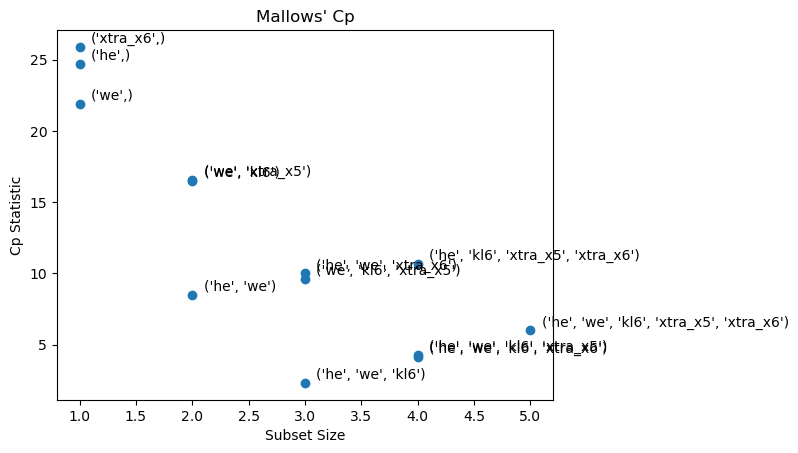

subsets         Cp
subsets                                                    
3       (he, we, kl6)                          3   2.319834
4       (he, we, kl6, xtra_x6)                 4   4.157104
        (he, we, kl6, xtra_x5)                 4   4.290008
5       (he, we, kl6, xtra_x5, xtra_x6)        5   6.000000
2       (he, we)                               2   8.466663
3       (we, kl6, xtra_x5)                     3   9.611771
        (he, we, xtra_x6)                      3   9.999213
4       (he, kl6, xtra_x5, xtra_x6)            4  10.636626
2       (we, kl6)                              2  16.504579
        (we, xtra_x5)                          2  16.548670
1       (we,)                                  1  21.873959
        (he,)                                  1  24.686913
        (xtra_x6,)                             1  25.889570

In [64]:
# Example 27: Mallows Cp (Family Income)

# First get some estimates from the full regression
edu_full = smf.ols('faminc ~ he + we + kl6 + xtra_x5 + xtra_x6', data=edu_inc).fit()
edu_full_sig2 = edu_full.mse_resid # residual MSE = sigma^2 hat
edu_n, _ = edu_inc.shape

# Negative Mallows' cp, so we want largest
def negative_mallows(estimator, X, y):
    y_pred = estimator.predict(X)
    sse = np.sum((y - y_pred) ** 2)
    p = estimator.n_features_in_ + 1 # number features doesn't include bias term
    cp = sse / edu_full_sig2 + 2*p - edu_n
    return -cp

# Set up regression
edu_Y = edu_inc['faminc'].values
edu_X = edu_inc.drop('faminc', axis=1)
lr = LinearRegression(fit_intercept=True)

# Using `ExhaustiveFeatureSelector` from `mlxtend`
edu_efs = EFS(lr,
              min_features=1,
              max_features=5,
              scoring=negative_mallows,
              cv=None)

# Run regressions
edu_efs.fit(edu_X, edu_Y)
print('Best subset:', [edu_efs.feature_names[i] for i in edu_efs.best_idx_])

# Extract Mallows' Cp data
edu_efs_features = [edu_efs.subsets_[p]['feature_names'] for p in edu_efs.subsets_]
edu_efs_subset = [len(edu_efs.subsets_[p]['feature_idx']) for p in edu_efs.subsets_]
edu_efs_cp = [ -edu_efs.subsets_[p]['avg_score'] for p in edu_efs.subsets_]
edu_mallows = pd.DataFrame({'subsets':edu_efs_subset, 'Cp':edu_efs_cp}, index=edu_efs_features)

# Top 3 best, by subset
edu_mallows_best = edu_mallows.groupby('subsets')[['subsets','Cp']].apply(lambda x: x.nsmallest(3, 'Cp'))
edu_mallows_best

# Plotting best subsets
plt.scatter(edu_mallows_best['subsets'], edu_mallows_best['Cp'])
plt.title("Mallows' Cp")
plt.xlabel('Subset Size')
plt.ylabel('Cp Statistic')
for i,sub in enumerate(edu_mallows_best['subsets']):
    subset = edu_mallows_best.index[i][1]
    plt.annotate(subset, (sub + 0.1, edu_mallows_best.iloc[i]['Cp'] + 0.3)) # to plot labels
plt.show()

# And the associated sorted data frame
edu_mallows_best.sort_values('Cp')

# As expected, Model 3 (faminc ~ he + we + kl6) is also the preferred choice by Cp

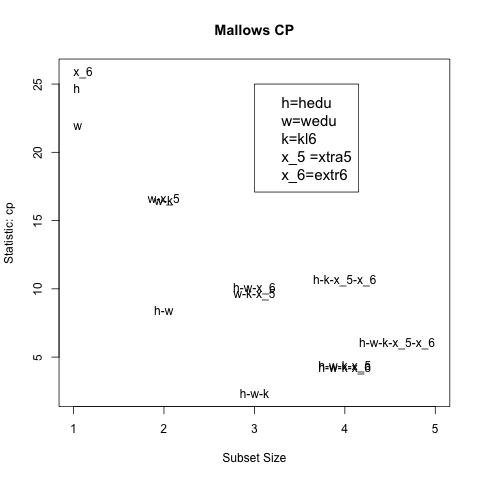

In [65]:
%%R

# We'll do the same as above, but in R

library(leaps)

edu_inc <- read.csv("data/edu_inc.csv")
edu_ss <- regsubsets(faminc ~ he + we + kl6 + xtra_x5 + xtra_x6, method = "exhaustive", nbest = 3, data = edu_inc)
subsets(edu_ss, statistic = "cp", legend = FALSE, main = "Mallows CP")
legend(3, 25 ,bty = "y", legend = c('h=hedu', 'w=wedu', 'k=kl6', 'x_5 =xtra5', 'x_6=extr6'),
       col = "steelblue4", cex = 1.25)

# As expected, Model 3 (faminc ~ he + we + kl6) is also the preferred choice by Cp

### 3.6.4 The Boruta Algorithm

Boruta is a variable importance selection algorithm based on the random forest algorithm. For more details, please see: https://www.datacamp.com/community/tutorials/feature-selection-R-boruta.

There are two primary implementations in Python, both trying to emulate the version in R. The first we'll look at is `BorutaPy`, which has some dependency issues with `numpy` data types. The second is `BorutaShap`; the package uses a deprecated version of binomial testing from the `stats` package, which is addressed in the `BorutaShap.py` file.

Of the two implementations in Python, the `BorutaShap` one is probably better, though the best advice would be to use the original R version.

In [66]:
# Example 28: Boruta (Wages, from CPS4)

### Boruta using `BorutaPy`

# Prepare data
cps_Y = cps['wage'].values
cps_X = cps.drop('wage', axis=1).values.astype(np.float32)

# To fix dependency issues with BorutaPy
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

# If you want to speed up computation time, consider parallel computing (n_jobs=-1)
rf = RandomForestRegressor(max_depth=5)
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=10, two_step=True) # `two_step` uses Bonferroni

# Run algorithm, X and y must by numpy arrays
boruta.fit(cps_X, cps_Y)

# Print confirmed columns
cps.drop('wage', axis=1).columns[boruta.support_]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	8
Iteration:

Index(['educ', 'exper', 'hrswk'], dtype='object')

In [67]:
# Compile feature decisions
boruta_keep = ['Confirmed' if c else
               'Tentative' if t else
               'Reject' for c,t in zip(boruta.support_, boruta.support_weak_)]

# Combine results and print
boruta_features = zip(cps.drop('wage', axis=1).columns, boruta.ranking_, boruta_keep)
for feat in boruta_features:
    print('Feature: {:<20} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

# These results seem to be a bit more strict than Boruta in R

Feature: educ                 Rank: 1,  Keep: Confirmed
Feature: exper                Rank: 1,  Keep: Confirmed
Feature: hrswk                Rank: 1,  Keep: Confirmed
Feature: married              Rank: 3,  Keep: Reject
Feature: female               Rank: 2,  Keep: Reject
Feature: metro                Rank: 4,  Keep: Reject
Feature: midwest              Rank: 7,  Keep: Reject
Feature: south                Rank: 7,  Keep: Reject
Feature: west                 Rank: 6,  Keep: Reject
Feature: black                Rank: 9,  Keep: Reject
Feature: asian                Rank: 5,  Keep: Reject


  0%|          | 0/100 [00:00<?, ?it/s]

4 attributes confirmed important: ['exper', 'female', 'educ', 'hrswk']
7 attributes confirmed unimportant: ['asian', 'west', 'midwest', 'south', 'black', 'metro', 'married']
0 tentative attributes remains: []


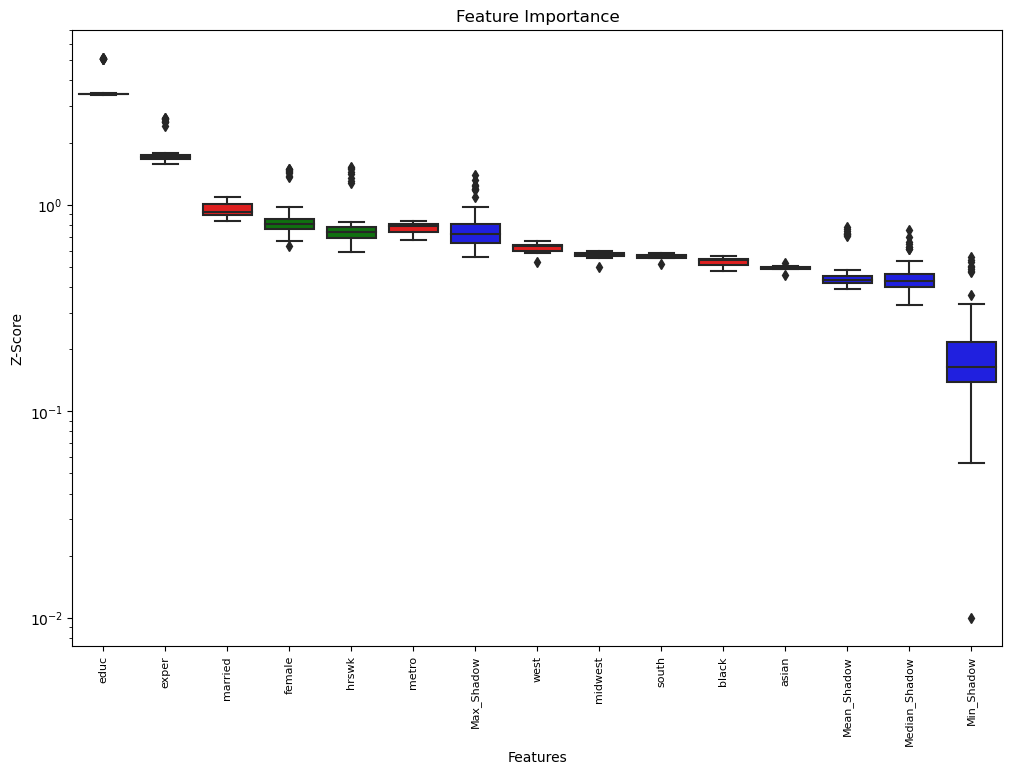

Feature: educ                 Rank: 1 (4.689),  Keep: Confirmed
Feature: exper                Rank: 4 (2.335),  Keep: Confirmed
Feature: hrswk                Rank: 2 (1.139),  Keep: Confirmed
Feature: married              Rank: 3 (1.062),  Keep: Reject
Feature: female               Rank: 5 (0.562),  Keep: Confirmed
Feature: metro                Rank: 6 (1.058),  Keep: Reject
Feature: midwest              Rank: 7 (0.610),  Keep: Reject
Feature: south                Rank: 8 (0.199),  Keep: Reject


In [68]:
### Boruta using `BorutaShap`
## Note: takes about 10 minutes

cps_X2 = cps.drop('wage', axis=1)

# Run Boruta algorithm
Feature_Selector = BorutaShap(importance_measure='shap', classification=False)
Feature_Selector.fit(X=cps_X2, y=cps_Y, n_trials=100, random_state=90095)

# Plot results
Feature_Selector.plot(which_features='all')
plt.show()

# Print results
boruta_keep2 = ['Confirmed' if p in Feature_Selector.accepted else
                'Tentative' if p in Feature_Selector.tentative else
                'Reject' for p in Feature_Selector.all_columns]

boruta_features2 = zip(Feature_Selector.all_columns,
                       len(Feature_Selector.shap_values) - np.argsort(Feature_Selector.shap_values),
                       Feature_Selector.shap_values,
                       boruta_keep2)
for feat in boruta_features2:
    print('Feature: {:<20} Rank: {} ({:.3f}),  Keep: {}'.format(feat[0], feat[1], feat[2], feat[3]))

           meanImp  medianImp     minImp    maxImp   normHits  decision
educ    47.4763937 47.2176841 41.4627375 55.601714 1.00000000 Confirmed
exper   13.7720040 14.0740051 11.0318056 17.824337 1.00000000 Confirmed
hrswk    8.0158853  8.2481989  4.3241175 11.620470 1.00000000 Confirmed
married  5.2875391  5.2924160  1.8369139  8.063755 0.83333333 Confirmed
female   7.9565093  7.9962609  4.2423468 11.531365 1.00000000 Confirmed
metro    6.0730523  5.8454113  3.0527108  9.212176 0.87500000 Confirmed
midwest  1.5684671  1.6213573 -0.7653519  4.316360 0.04166667  Rejected
south   -0.3209318 -0.4312132 -2.0554501  3.169285 0.00000000  Rejected
west    -0.2552186 -0.5271020 -1.9463034  3.188131 0.00000000  Rejected
black    1.3948835  1.0291949 -0.8740238  3.907392 0.08333333  Rejected
asian    1.2352893  1.2878400 -0.6747413  3.395988 0.04166667  Rejected


 1. run of importance source...
 2. run of importance source...
 3. run of importance source...
 4. run of importance source...
 5. run of importance source...
 6. run of importance source...
 7. run of importance source...
 8. run of importance source...
 9. run of importance source...
 10. run of importance source...
 11. run of importance source...
After 11 iterations, +0.91 secs: 
 confirmed 4 attributes: educ, exper, female, hrswk;
 rejected 2 attributes: south, west;
 still have 5 attributes left.

 12. run of importance source...
 13. run of importance source...
 14. run of importance source...
 15. run of importance source...
After 15 iterations, +1.2 secs: 
 rejected 2 attributes: asian, midwest;
 still have 3 attributes left.

 16. run of importance source...
 17. run of importance source...
 18. run of importance source...
After 18 iterations, +1.4 secs: 
 confirmed 1 attribute: metro;
 rejected 1 attribute: black;
 still have 1 attribute left.

 19. run of importance source

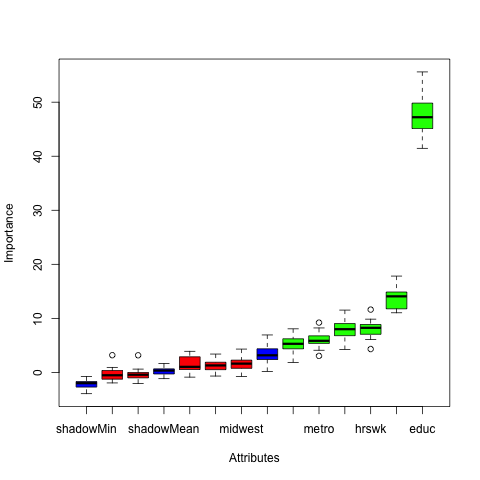

In [69]:
%%R
library(Boruta)

# This is the preferred version

set.seed(90095)
cps4_small <- read.csv("data/cps4_small.csv")
cps_boruta <- Boruta(wage ~ ., data = cps4_small, doTrace = 2)

plot(cps_boruta, sort = TRUE)
attStats(cps_boruta)

### 3.6.5 Stepwise Regression
Since our goal is ultimately about making the best predictions possible with our model, *Stepwise Regression* consists of iteratively adding and removing predictors until the model with the lowest prediction error is obtained. There are 3 popular ways to perform this:

* **Forward Selection**

    Start with no predictors in the model, iteratively add the most contributive predictors, and stop when the improvement is no longer statistically significant.
* **Backward Selection**

    Starts with all predictors in the model (full model), iteratively remove the least contributive predictors, and stop when you have a model where all predictors are statistically significant.

* **Stepwise Selection**

    Is a combination of forward and backward selections. You start with no predictors, then sequentially add the most contributive predictors (like forward selection). After adding each new variable, remove any variables that no longer provide an improvement in the model fit (like backward selection).

Below we show a brute force approach by manually comparing models based on their prediction accuracy.

In [70]:
# Example 29: Evaluating the Predictor Error

# Train-test split
bos_train,bos_test = train_test_split(boston, train_size=0.8, random_state=90095)

def test_performance(model, test_X, test_Y):
    sse = np.sum((test_Y - model.predict(test_X)) ** 2)
    return [np.sqrt(sse / len(test_Y)), model.rsquared, model.rsquared_adj]

# Fit model 1
boston_vars = "+".join(boston.columns.drop('medv'))
boston_mod = smf.ols('medv ~' + boston_vars, bos_train).fit()
boston_perf = pd.DataFrame({
    'mod_1': test_performance(boston_mod, test_X=bos_test.drop('medv', axis=1), test_Y=bos_test['medv'])
}, index=['RMSE', 'R-squared', 'Adj R-squared'])
# We will compare this model soon

# --- (From Example 21) ---
# VIF computation setup
boston_exog = boston.drop('medv', axis=1) # exogenous variables only
boston_exog_vars = boston_exog.columns
boston_exog = sm.add_constant(boston_exog)

# Compute VIF
boston_VIF = []
for i,v in enumerate(boston_exog_vars):
    boston_VIF.append(variance_inflation_factor(exog=boston_exog, exog_idx=i+1)) # `exog_idx` is col index of predictor
# Print
pd.DataFrame({
    'Variable':boston_exog_vars,
    'VIF':boston_VIF
}).sort_values(by='VIF')

# We might remove "tax", for multicollinearity

,Variable,VIF
3,chas,1.073995
11,black,1.348521
0,crim,1.792192
10,ptratio,1.799084
5,rm,1.933744
1,zn,2.298758
12,lstat,2.941491
6,age,3.100826
7,dis,3.955945
2,indus,3.991596


In [71]:
# Fit model 2
boston_vars2 = '+'.join(boston.columns.drop(['medv', 'tax']))
boston_mod2 = smf.ols('medv ~' + boston_vars2, bos_train).fit()
boston_perf['mod_2'] = test_performance(boston_mod2, test_X=bos_test.drop('medv', axis=1), test_Y=bos_test['medv'])

# Comparing testing performance
boston_perf.T

# Looks like removing "tax" didn't help much

# Ideally, we could manually run through all the plausible models until we converge on the best one.
# That would be very inefficient

,RMSE,R-squared,Adj R-squared
mod_1,5.076289,0.755124,0.746961
mod_2,4.976544,0.746535,0.738756


In Python, we can use the `SequentialFeatureSelector` from `mlxtend` for forward and backward stepwise methods to automatically do the model selection process. In R, you might use the `leaps` library, with the `step` (or `stepAIC`) function.

For example 27, we used an exhaustive search (`ExhaustiveFeatureSelector`) with Mallows' Cp to determine model specification. Stepwise regressions finds the best performing subset for a given number of features and keeps them in the model; using those features, you either add another variable or take one away, depending on the direction of your steps. In a way, you are tracing the path of best performance.

Best subset: ['he', 'we', 'kl6'] 

                                 subsets           AIC
(he, we, kl6)                          3  10292.730820
(he, we, kl6, xtra_x6)                 4  10294.565870
(he, we, kl6, xtra_x5, xtra_x6)        5  10296.406561
(he, we)                               2  10298.908597
(we,)                                  1  10311.959827


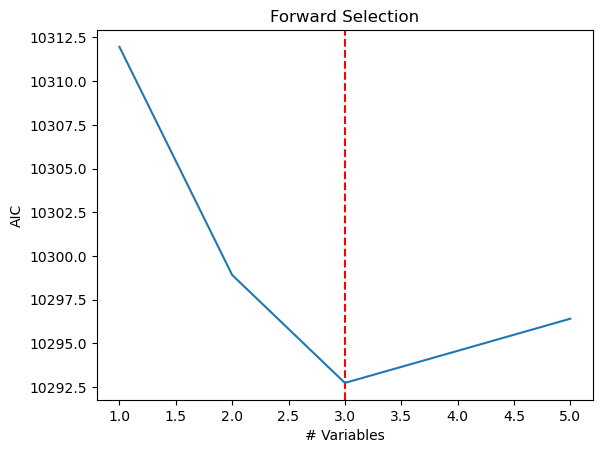

In [72]:
# Example 30: Stepwise Regressions (Family Income)

# Negative AIC, so we want largest
def negative_AIC(estimator, X, y):
    model = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()
    return -model.aic

# Could also use (negative) BIC: (-)model.bic
# Note that BIC is more restrictive

# Set up regression
edu_Y = edu_inc['faminc'].values
edu_X = edu_inc.drop('faminc', axis=1)
lr = LinearRegression(fit_intercept=True)


### FIRST: Forward Selection

# Using `SequentialFeatureSelector` from `mlxtend`
edu_forward = SFS(lr,
                  forward=True,
                  k_features=(1,5),
                  scoring=negative_AIC,
                  cv=None)

# Run regressions
edu_forward.fit(edu_X, edu_Y)
print('Best subset:', [n for n in edu_forward.k_feature_names_], '\n')

# Extract subset data
edu_fwd_metrics = edu_forward.get_metric_dict()
edu_fwd_features = [edu_fwd_metrics[p]['feature_names'] for p in edu_fwd_metrics]
edu_fwd_subset = [len(edu_fwd_metrics[p]['feature_idx']) for p in edu_fwd_metrics]
edu_fwd_aic = [ -edu_fwd_metrics[p]['avg_score'] for p in edu_fwd_metrics]
edu_forward_df = pd.DataFrame({'subsets':edu_fwd_subset, 'AIC':edu_fwd_aic}, index=edu_fwd_features)

# Ranked by AIC
print(edu_forward_df.sort_values(by='AIC'))

# Plotting
plt.axvline(x=np.argmin(edu_forward_df['AIC']) + 1, linestyle='--', color='red')
plt.plot(edu_forward_df['subsets'], edu_forward_df['AIC'])
plt.title('Forward Selection')
plt.xlabel('# Variables')
plt.ylabel('AIC')
plt.show()

# Best model has 3 features

Best subset: ['he', 'we', 'kl6'] 

                                 subsets           BIC
(he, we, kl6)                          3  10308.967312
(he, we)                               2  10311.085967
(he, we, kl6, xtra_x6)                 4  10314.861486
(we,)                                  1  10320.078074
(he, we, kl6, xtra_x5, xtra_x6)        5  10320.761301


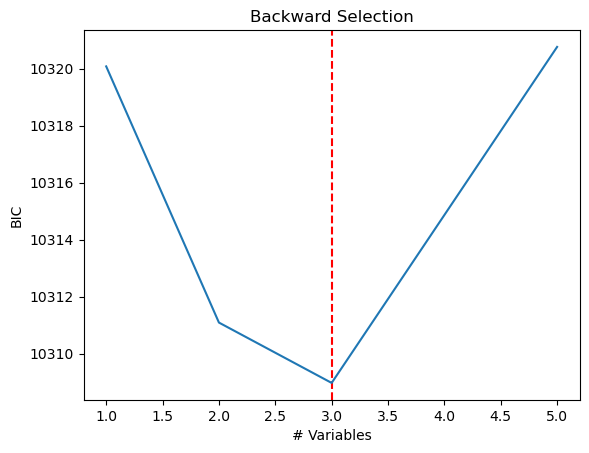

In [73]:
### SECOND: Backward Selection

# Negative BIC, so we want largest
def negative_BIC(estimator, X, y):
    model = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()
    return -model.bic

# Initialize sequential selection
edu_backward = SFS(lr,
                  forward=True,
                  k_features=(1,5),
                  scoring=negative_BIC, # trying with BIC
                  cv=None)

# Run regressions
edu_backward.fit(edu_X, edu_Y)
print('Best subset:', [n for n in edu_backward.k_feature_names_], '\n')

# Extract subset data
edu_bwd_metrics = edu_backward.get_metric_dict()
edu_bwd_features = [edu_bwd_metrics[p]['feature_names'] for p in edu_bwd_metrics]
edu_bwd_subset = [len(edu_bwd_metrics[p]['feature_idx']) for p in edu_bwd_metrics]
edu_bwd_bic = [ -edu_bwd_metrics[p]['avg_score'] for p in edu_bwd_metrics]
edu_backward_df = pd.DataFrame({'subsets':edu_bwd_subset, 'BIC':edu_bwd_bic}, index=edu_bwd_features)

# Ranked by BIC
print(edu_backward_df.sort_values(by='BIC'))

# Plotting
plt.axvline(x=np.argmin(edu_backward_df['BIC']) + 1, linestyle='--', color='red')
plt.plot(edu_backward_df['subsets'], edu_backward_df['BIC'])
plt.title('Backward Selection')
plt.xlabel('# Variables')
plt.ylabel('BIC')
plt.show()

# Again, best model has 3 features

# <font face="garamond" size="14" color="#122DAC">4. Heteroskedasticity</font>

The classic signature of heteroskedasticity is a growing spread in $y$ with increasing values of $x$. In this case the *Constant Variance* assumption no longer holds, and we therefore need to apply other techniques to mitigate this problem.

Consider the MR model: $y_{i}=\beta_1 + \beta_2 x_{i2} + \cdots + \beta_K x_{iK} + e_i$. If the variance $\rm Var(y_i) = E(e_{i}^{2})$ is no longer constant, this suggests that there is a function $h()$ that depends on predictors $z_2, \ldots,z_S$ that can be used to characterize the behavior of $\rm Var(y_i)$. For example, we can propose 

$$
{\rm var}(y_i) = E(e_{i}^{2}) = h(\alpha_1 + \alpha_2 z_{i2} + \cdots + \alpha_{S}z_{iS}).
$$

This is more general result since the constant variance assumption holds provided $\alpha_2 = \alpha_3 = \cdots =\alpha_S=0$.

Next, we will discuss a couple of statistical methods to help us identify if heteroskedasticity is present by evaluating hypotheses such as $H_0: \alpha_2 = \alpha_3 = \cdots =\alpha_S=0$ and examining plausible function forms for $h()$ such as linear, quadratic and exponential functions. 

## 4.1 Detecting Heteroskedasticity

### 4.1.1 Spread Level Plots

These can be used as a diagnostic for nonconstant variance with the advantage that it also yields an estimate for the power law transformation to use for the response variable.

In [74]:
# Example 31: Spread Level Plot (Food)

food = pd.read_csv('data/food.csv')

# Traditional least squares
food_mod = smf.ols('food_exp ~ income', data=food).fit()
print(food_mod.summary())

                            OLS Regression Results                            
Dep. Variable:               food_exp   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     23.79
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           1.95e-05
Time:                        08:50:40   Log-Likelihood:                -235.51
No. Observations:                  40   AIC:                             475.0
Df Residuals:                      38   BIC:                             478.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     83.4160     43.410      1.922      0.0

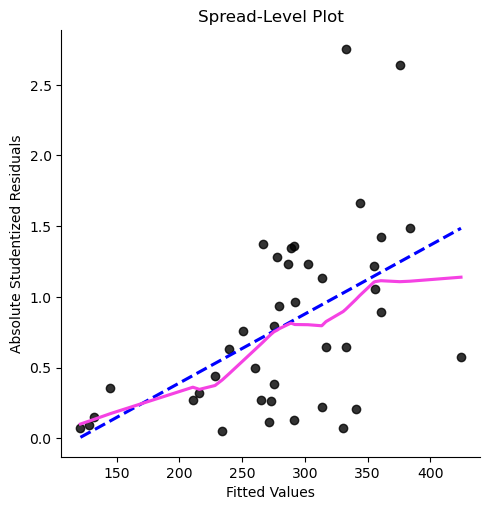

Suggested power transform: -1.1069


In [75]:
# Extract studentized residuals
food_mod_std_resid = food_mod.get_influence().resid_studentized_external # STUDENTIZED residuals
food_mod_spreadlevel = pd.DataFrame({
    'Fitted Values':food_mod.fittedvalues,
    'Absolute Studentized Residuals':np.abs(food_mod_std_resid)
})

# Plot spread-level plot
sns.lmplot(food_mod_spreadlevel, x='Fitted Values', y='Absolute Studentized Residuals',
           line_kws={'color':'blue', 'linestyle':'--'}, ci=False, scatter_kws={'color':'black'})
sns.regplot(food_mod_spreadlevel, x='Fitted Values', y='Absolute Studentized Residuals',
            color='#f542e3', lowess=True, scatter=False)
plt.title('Spread-Level Plot')
plt.show()

# Power transform
## Formula: lambda = 1 - slope(RLM), where RLM is Robust Linear Model of (log(abs studentized residuals) ~ log(fitted))
food_mod_rlm = RLM(endog=np.log(np.abs(food_mod_std_resid)),            # y = log absolute studentized residuals
                   exog=sm.add_constant(np.log(food_mod.fittedvalues))  # x = log fitted values
                   ).fit()

print(f'Suggested power transform: {1 - food_mod_rlm.params[0]:.4f}')
# Index is 0 because x was unlabeled; the other (0-place) estimate has index 'const'

# It suggests a lambda = -1.107 for the power law to use in transforming y.

## 4.2 Score Tests for Nonconstant Error Variance

There are several popular tests for Heteroskedasticity depending on various characteristics of the data. In this section, however, we will focus on:

1. Breusch-Pagan Test
2. White Test
3. Goldfeld-Quandt Test

### 4.2.1 Lagrange Multiplier Test (Breusch-Pagan Test)

Assuming we know what the $z_s$'s are, this test is for the null $H_0: \alpha_2 = \alpha_3 = \cdots =\alpha_S=0$ against the alternative $H_1:\text{not all the }\alpha_s\text{ are zero}$. The respective test-statistic is $\chi^2 \sim N\times R^2 \sim \chi^{2}_{S-1}$, where $R^2$ is obtained from the regression: $\widehat{e_i}^{2} = \alpha_1 + \alpha_2 z_{i2} + \cdots + \alpha_S z_{iS}+v_i$. The challenge with this test is that we may not not know (or have) other predictors $z_s$ for estimating the $\alpha_{s}$'s.

We'll first do it by hand then use `statsmodels`.

In [76]:
# Example 32: BP Test (Food)

alpha = 0.05

# Resid^2 from full model
food_mfull_ressq = food_mod.resid**2
food_df2 = pd.DataFrame({
    'resid2':food_mfull_ressq,
    'income':food['income']
})

# Test equation
food_m2 = smf.ols('resid2 ~ income', food_df2).fit()
food_n = food_m2.nobs
food_k = len(food_m2.params) # number estimates
food_m2_r2 = food_m2.rsquared
food_m2_chisq = food_n * food_m2_r2
food_m2_pval = chi2.sf(food_m2_chisq, food_k-1) # survival function (sf = 1 - cdf)
# Critical value
food_m2_crit = chi2.ppf(1-alpha, food_k-1) # percent point function (equivalent to qchisq() in R)

print('Critical value: \t{:.5f}\nTest statistic: \t{:.5f}\np-value: \t\t{:.5f}'
      .format(food_m2_crit, food_m2_chisq, food_m2_pval))

# Since p-val < 0.05, we reject the null and conclude that heteroskedasticity is present.

Critical value: 	3.84146
Test statistic: 	7.38442
p-value: 		0.00658


In [77]:
# We can do a BP test using `statsmodels.stats.diagnostic`

# output[0] = statistic, food_bp[1] = p-value
food_bp = het_breuschpagan(resid=food_mod.resid, exog_het=sm.add_constant(food['income']))
print(f'Test statistic: \t{food_bp[0]:.5f}\np-value: \t\t{food_bp[1]:.5f}')

Test statistic: 	7.38442
p-value: 		0.00658


### 4.2.2 White Test

Given the problem we saw with the Breusch-Pagan (BP) Test, the *White Test* solves this by suggesting we start by using our existing predictors from the original model. For example, if our regression model is $E(y)=\beta_1 + \beta_2 x_{2} + \beta_3 x_{3}$, then we set $z_2 =x_2$, $z_3 =x_3$, $z_4 =x_{2}^{2}$, and $z_5 =x_{3}^{2}$.

We'll first do it by hand then use `statsmodels`.

In [78]:
# Example 33: White Test (Food)

# Test equation
food_m3 = smf.ols('resid2 ~ income + I(income**2)', food_df2).fit()
food_n = food_m3.nobs
food_k = len(food_m3.params) # number estimates
food_m3_r2 = food_m3.rsquared
food_m3_chisq = food_n * food_m3_r2
food_m3_pval = chi2.sf(food_m3_chisq, food_k-1)
# Critical value
food_m3_crit = chi2.ppf(1-alpha, food_k-1)

print('Critical value: \t{:.5f}\nTest statistic: \t{:.5f}\np-value: \t\t{:.5f}'
      .format(food_m3_crit, food_m3_chisq, food_m3_pval))

# Since p-val < 0.05, we reject the null and conclude that heteroskedasticity is present.

Critical value: 	5.99146
Test statistic: 	7.55508
p-value: 		0.02288


In [79]:
# Similarly, we can do a White test using `statsmodels.stats.diagnostic`

# output[0] = statistic, output[1] = p-value
food_white = het_white(resid=food_mod.resid, exog=sm.add_constant(food['income']))
print(f'Test statistic: \t{food_white[0]:.5f}\np-value: \t\t{food_white[1]:.5f}')

Test statistic: 	7.55508
p-value: 		0.02288


### 4.2.3 Goldfeld-Quandt Test

When our model includes a factor variable(s), and suffers from heteroskedasticty, the Goldfeld-Quandt Test can be useful for comparing groups based on the factor levels. For example, consider the case of a binary indicator variable ($I$) that takes on the values 0 or 1. The test will compares the variances of the two groups by testing the null hypothesis $H_0:\sigma^{2}_{1} = \sigma^{2}_{0}$ against the alternative: $H_0:\sigma^{2}_{1} \neq \sigma^{2}_{0}$. The respective test statistic is $F=\sigma^{2}_{1}/\sigma^{2}_{0}$ which is then compared against $F_c = F_{N_1 - K, N_0 -K}$. This test can also be applied to a model with only quantitative predictors by simply splitting the observations according to a desired rule. The two examples below show these cases.

In [80]:
# Example 34: Goldfeld-Quandt Test, Indicator Variable (cps5)

cps5 = pd.read_csv('data/cps5.csv')
# Create 2 groups: metro (m) and rural (r)
cps5_m = cps5.loc[cps5['metro'] == 1]
cps5_r = cps5.loc[cps5['metro'] == 0]
# Fit models
wg_m = smf.ols('wage ~ educ + exper', cps5_m).fit()
wg_r = smf.ols('wage ~ educ + exper', cps5_r).fit()
# Residual degrees of freedom
wg_m_df = wg_m.df_resid
wg_r_df = wg_r.df_resid
# Sigma^2 estimates
wg_m_sig2 = wg_m.mse_resid # larger
wg_r_sig2 = wg_r.mse_resid
# F statistic
wg_F = wg_m_sig2 / wg_r_sig2 # larger in numerator
f
wg_Fcrit = f.ppf(1-alpha/2, wg_m_df, wg_r_df)
wg_pval = f.sf(wg_F, wg_m_df, wg_r_df)

print('Upper critical: \t{:.5f}\nTest statistic: \t{:.5f}\np-value: \t\t{:.5f}'
      .format(wg_Fcrit, wg_F, wg_pval))

Upper critical: 	1.07574
Test statistic: 	2.33981
p-value: 		0.00000


In [81]:
# Similarly, we can do a GQ test using `statsmodels.stats.diagnostic`

metro_ratio = np.sum(cps5['metro'] == 0) / cps5.shape[0]

# output[0] = statistic, output[1] = p-value
cps5_gq = het_goldfeldquandt(y=cps5['wage'], x=sm.add_constant(cps5[['educ', 'exper', 'metro']]),
                             idx=3, split=metro_ratio) # idx= index of reference column, split=proportion
print(f'Test statistic: \t{cps5_gq[0]:.5f}\np-value: \t\t{cps5_gq[1]:.5f}')

Test statistic: 	2.33981
p-value: 		0.00000


In [82]:
# Example 35: Goldfeld-Quandt Test, Quantitative Predictors (Food)

med_income = np.median(food['income'])
# Partition data
inc_low = food.loc[food['income'] <= med_income]
inc_high = food.loc[food['income'] > med_income]
# Fit models
inc_l_mod = smf.ols('food_exp ~ income', inc_low).fit()
inc_h_mod = smf.ols('food_exp ~ income', inc_high).fit()
# Residual degrees of freedom
inc_l_mod_resdf = inc_l_mod.df_resid
inc_h_mod_resdf = inc_h_mod.df_resid
# Sigma^2 estimates
inc_l_mod_sig2 = inc_l_mod.mse_resid
inc_h_mod_sig2 = inc_h_mod.mse_resid # larger
# F statistic
inc_F = inc_h_mod_sig2 / inc_l_mod_sig2 # larger in numerator
inc_Fcrit = f.ppf(1-alpha/2, inc_h_mod_resdf, inc_l_mod_resdf)
inc_pval = f.sf(inc_F, inc_h_mod_resdf, inc_l_mod_resdf)

print('Upper critical: \t{:.5f}\nTest statistic: \t{:.5f}\np-value: \t\t{:.5f}'
      .format(inc_Fcrit, inc_F, inc_pval))

# Since p-val < 0.05, we reject the null and conclude that heteroskedasticity is present.
# In this case, we can see that the test suggests that there is a higher variance at higher incomes.

Upper critical: 	2.59559
Test statistic: 	3.61476
p-value: 		0.00460


In [83]:
# Similarly, we can do a GQ test using `statsmodels.stats.diagnostic`

# output[0] = statistic, output[1] = p-value
food_gq = het_goldfeldquandt(y=food['food_exp'], x=sm.add_constant(food['income']))
print(f'Test statistic: \t{food_gq[0]:.5f}\np-value: \t\t{food_gq[1]:.5f}')

Test statistic: 	3.61476
p-value: 		0.00460


## 4.3 Mitigating Heteroskedasticity

In the previous sections we learned how to detect heteroskedasticity, now we will discuss what to with our model to mitigate it its impact.

### 4.3.1 Heteroskedasticity-Consistent Standard Errors

Recall that heteroskedasticity has the two effects: (1) the LS estimators are no longer the best, and (2) the LS standard errors are not correct since the variance is no longer constant. A more robust (in the sense that it applies to both heteroskedastic and homoskedastic errors) is the *White Statndard Error* as given by:

$$
{\rm var} (\widehat{b}_2) = \frac{N}{N-2} \cdot \frac{\sum_{i={1}}^{N} \left[(x_i - \overline{x})^2 \widehat{e}_{i}^{2} \right]}{\sum_{i={1}}^{N} \left[ (x_i - \overline{x})^2\right]^2}
$$

For example, we look at the results from the food expenditure case and compare the traditional vs. the White standard errors, as well as the respective confidence intervals for the model coefficients. Keep in mind that hypotheses such as, e.g., $\lambda = c_1\beta_1 + c_2\beta_2 =c_0$ would also require us to update the standard errors, and therefore, our conclusions may change.

<img src="images/L2_fig6.png" alt="White standard error correction" height="100">

<img src="images/L2_fig7.png" alt="White confidence interval correction" height="65">

Luckily in Python, HC1 standard errors (and the family of HC0, HC1, HC2, and HC3) are all easily accessible. For a `statsmodel` OLS result, you can use `model.HC1_se`. Uncorrected standard errors are `model.bse`.

In [84]:
# Example 36: White SE (Food)

def coef_summary(model):
    summary = pd.DataFrame({
        'coef':model.params,
        'se':model.bse,             # standard error (no corrections)
        't-stat':model.tvalues,
        'p-val':model.pvalues
    })
    return summary

# One method: Use existing fitted regression
food_mod = smf.ols('food_exp ~ income', data=food).fit()
food_mod_coef = coef_summary(food_mod)
food_mod_HC1 = food_mod.get_robustcov_results(cov_type='HC1') # Using existing model
food_mod_HC1_coef = coef_summary(food_mod_HC1)

print('--- Uncorrected ---\n{}\n\n\n--- HC1 Corrected ---\n{}'.format(food_mod_coef, food_mod_HC1_coef))

--- Uncorrected ---
                coef         se    t-stat     p-val
Intercept  83.416002  43.410163  1.921578  0.062182
income     10.209643   2.093264  4.877381  0.000019


--- HC1 Corrected ---
        coef         se    t-stat     p-val
0  83.416002  27.463748  3.037313  0.004299
1  10.209643   1.809077  5.643565  0.000002


In [85]:
# Second method: Fit two models
food_model = smf.ols('food_exp ~ income', data=food)
food_mod = food_model.fit()                 # uncorrected
food_hc1 = food_model.fit(cov_type='HC1')   # HC1 corrected
# Coefficient summaries
food_mod_coef = coef_summary(food_mod)
food_mod_HC1_coef = coef_summary(food_hc1)

print('--- Uncorrected ---\n{}\n\n\n--- HC1 Corrected ---\n{}'.format(food_mod_coef, food_mod_HC1_coef))
# Same results

--- Uncorrected ---
                coef         se    t-stat     p-val
Intercept  83.416002  43.410163  1.921578  0.062182
income     10.209643   2.093264  4.877381  0.000019


--- HC1 Corrected ---
                coef         se    t-stat         p-val
Intercept  83.416002  27.463748  3.037313  2.386973e-03
income     10.209643   1.809077  5.643565  1.665641e-08


In [86]:
# Hypothesis testing with HC1 standard errors

h0 = np.array([0, 1, 1]) # H0: b2 + b3 = 0

# Fitting 'andy' dataset
andy_model = smf.ols('sales ~ price + advert', data=andy)
andy_mod = andy_model.fit()
andy_hc1 = andy_model.fit(cov_type='HC1') # corrected

# Uncorrected
print('Uncorrected:\t', andy_mod.f_test(h0))

# Corrected
print('HC1:\t\t', andy_hc1.f_test(h0))

# In this case the p-value is larger using the traditional errors.

Uncorrected:	 <F test: F=22.441454202881115, p=1.0586899360487892e-05, df_denom=72, df_num=1>
HC1:		 <F test: F=23.38698389900667, p=7.292175323798992e-06, df_denom=72, df_num=1>


### 4.3.2 Generalized  (Weighted) Least Squares

To properly deal with heteroskedasticity, we would need to estimate a different variance of the error term for each observation. On a practical level this is not possible, and instead we model the dependence of the variance on one or more of the predictors in the model. We will examining two forms of dependence depending on whether we know or not the actual relationship between the variance and predictor(s).

### 4.3.3 Known Form or Variance

For simplicity, let's assume we have a SLR model $y_i = \beta_1 + \beta_2 x_i + e_i$ and that $\rm Var(e_i) = \sigma_{i}^{2} = \sigma^2 x_i$. If we divide our original model by $\sqrt{x_i}$, then we show that in the transformed model:  $y_{i}^{*} = \beta_1 x_{i1}^{*} + \beta_2 x_{i2}^{*} + e_{i}^{*}$, $e_{i}^{*}$ are now homoskedastic since $\rm Var(e_{i}^{*}) =\rm Var \left(e_i/\sqrt{x_i}\right) = \rm Var (e_i)/x_i = \sigma^2 x_i/x_i = \sigma^2$. Also, the desired properties $E(e_{i}^{*}) =0$ and $\rm Cov(e_{i}^{*}, e_{j}^{*})=0,\phantom/ i\neq j$ still hold.

The transformation we proposed is part of a more general method known as *Weighted Least Squares* where we weighted the errors by $x_{i}^{-1/2}$.

For example, looking again at the food expenditure example, applying this method we obtain:

<img src="images/L2_fig8.png" alt="Weighted model, known form" height="100">

<img src="images/L2_fig9.png" alt="Weighted confidence interval" height="65">

In [87]:
# Example 37: Weighted Least Squares, Known Variance (Food)

# Traditional LS
food_mod = smf.ols('food_exp ~ income', data=food).fit()
print(coef_summary(food_mod))

# Weighted LS, known form
w = (1/food['income']) # Weights: statsmodels takes sqrt by default, so w = 1/x
food_w = smf.wls('food_exp ~ income', data=food, weights=w).fit()
print(coef_summary(food_w))

                coef         se    t-stat     p-val
Intercept  83.416002  43.410163  1.921578  0.062182
income     10.209643   2.093264  4.877381  0.000019
                coef         se    t-stat         p-val
Intercept  78.684080  23.788722  3.307621  2.064130e-03
income     10.451009   1.385891  7.541002  4.613763e-09


### 4.3.4 Unknown Form of Variance

This case is also known as Feasible Generalized Least Squares (FGLS).

If we do not know the form of the variance, we can propose a more general power law form such as $\rm Var(e_i) = \sigma_{i}^{2} = \sigma^2 x_{i}^{\gamma}$, where $\gamma$ is an unknown parameter that we can estimate. The trick to estimating $\gamma$ is to take logs on both side of the variance equation, $\ln(\sigma_{i}^{2}) = \ln(\sigma^2) + \gamma \ln(x_i)$, and take the exponential on both sides,

$$\sigma_{i}^{2} = \exp\left[\ln(\sigma^2) + \gamma \ln(x_i)\right] = \exp(\alpha_1 + \alpha_2 z_i),$$
where $\alpha_1 = \ln(\sigma^2)$, $\alpha_2 = \gamma$, and $z_i = \ln(x_i)$. For the MR case, we simply have more terms, $z_{iS}$ to include in the exponential function. We can use traditional LS to estimate $\gamma$ from the log-linear model $\ln(\sigma_{i}^{2}) = \alpha_1 + \alpha_2 z_i$. The estimated equation is $\widehat{\ln(\sigma_{i}^{2}}) = 0.9378 + 2.39z_i$ (recall that we used $\gamma = 1$ in our previous example). Now we can use $\widehat{\sigma}^{2}_{i} = \exp(0.9378 + 2.39z_i)$ to transform our original model instead of the $x_{i}^{-1/2}$ weights. The estimated model is now:

<img src="images/L2_fig10.png" alt="Weighted confidence interval, unknown form" height="100">

In [88]:
# Example 38: Weighted Least Squares, Unknown Variance (Food)

# Traditional LS
food_mod = smf.ols('food_exp ~ income', data=food).fit()

# Weighted LS, known form
ehatsq = food_mod.resid**2
sig2hat_mod = sm.OLS(endog=np.log(ehatsq),
                     exog=sm.add_constant(np.log(food['income']))).fit()
vari = 1 / np.exp(sig2hat_mod.fittedvalues)
food_fgls = smf.wls('food_exp ~ income', data=food, weights=vari).fit()


# Comparing model summaries
food_mod_compare = summary_col([food_mod, food_hc1, food_w, food_fgls],
                               float_format='%0.3f',
                               stars = False,
                               model_names=['OLS', 'HC1', 'WLS', 'FGLS'],
                               regressor_order=['Intercept', 'income'])
print(food_mod_compare)


                 OLS      HC1      WLS      FGLS 
-------------------------------------------------
Intercept      83.416   83.416   78.684   76.054 
               (43.410) (27.464) (23.789) (9.713)
income         10.210   10.210   10.451   10.633 
               (2.093)  (1.809)  (1.386)  (0.972)
R-squared      0.385    0.385    0.599    0.759  
R-squared Adj. 0.369    0.369    0.589    0.753  
Standard errors in parentheses.


# <font face="garamond" size="14" color="#122DAC">5. Missing Observations</font>

There are several ways to deal with missing data depending on their characteristics and volume. Below we briefly discuss four of them.

1. **Remove Missing Observations**

    If the number of missing observations is small relative to the dataset, we can simply remove these observations. Also, we need to make sure not to introduce a bias due to their removal by e.g., failing to represent certain characteristics of the data.

2. **Remove the Variable**

    This may be appropriate if most of the missing values occur mainly in a particular variable. We would need to weigh its removal against other considerations such as economic significance, etc.

3. **Imputation via Mean/Median/Mode**

    Depending on the distribution of the observations, we can impute the missing data with estimates of the Mean, Median or Mode.

4. **Prediction**

    We can predict the missing observations using kNN (k-Nearest Neighbor), regression, interpolation, etc. However, of all these methods, kNN seems to work well provided the variables are not factor variables. The basic idea behind the method is to replace a missing observation with a weighted average of the closest (using the Euclidean distance) $k$ neighbors. In the case of factor variables, we can instead use *Recursive Partitioning* (We normally cover this when discussing *Regression Trees*).

In [89]:
# Example 39: Missing Values (Boston)

random.seed(90095)

# Introduce missing values
boston2 = boston.copy()
rad_col = [ind for ind,col in enumerate(boston2.columns) if 'rad' in col][0]
ptratio_col = [ind for ind,col in enumerate(boston2.columns) if 'ptratio' in col][0]
na_insert = np.arange(boston2.shape[0])

# Randomize and insert
random.shuffle(na_insert)
rad_rows = na_insert[:40]
boston2.iloc[rad_rows, rad_col] = np.nan

random.shuffle(na_insert)
ptratio_rows = na_insert[:40]
boston2.iloc[ptratio_rows, ptratio_col] = np.nan

# Quick look at the missing values
boston2.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1.0,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2.0,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2.0,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3.0,222,NaN,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3.0,222,18.7,396.90,5.33,36.2


In [90]:
# Just to check, print missing values
boston2.isnull().sum()

crim        0
zn          0
indus       0
chas        0
nox         0
rm          0
age         0
dis         0
rad        40
tax         0
ptratio    40
black       0
lstat       0
medv        0
dtype: int64

In [91]:
### Method 1: Remove missing observations

na_mod1 = smf.ols('medv ~ rad + ptratio', data=boston2, missing='drop').fit()
print(na_mod1.summary()) # resulting model

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     87.66
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           1.30e-32
Time:                        08:50:41   Log-Likelihood:                -1491.0
No. Observations:                 429   AIC:                             2988.
Df Residuals:                     426   BIC:                             3000.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.8717      3.531     16.956      0.0

In [92]:
### Method 2: Remove the variable

# Simply leave it out of the regression model, not much more to do :)

In [93]:
### Method 3: Impute with Mean/Median/Mode

def error_measures(errors, original):
    mae = np.mean(np.abs(errors))
    mse = np.mean(errors**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(errors / original))
    return {'MAE':mae, 'MSE':mse, 'RMSE':rmse, 'MAPE':mape}

# Compute median and mean, excluding nan values
boston_means = {'rad':np.nanmedian(boston2['rad']), 'ptratio':np.nanmean(boston2['ptratio'])}
boston3 = boston2.fillna(value=boston_means)

# How far are these from the true values?
b3_rad_diff = boston.iloc[rad_rows, rad_col] - np.nanmean(boston2['rad'])
b3_ptratio_diff = boston.iloc[ptratio_rows, ptratio_col] - np.nanmean(boston2['ptratio'])

rad_misclass = np.mean(boston3['rad'][rad_rows] != boston['rad'][rad_rows]) # misclassification rate

# Print error measures
b3_diff = pd.DataFrame({
    'rad':error_measures(b3_rad_diff, boston.iloc[rad_rows, rad_col]),
    'ptratio':error_measures(b3_ptratio_diff, boston.iloc[ptratio_rows, ptratio_col])
})

print(b3_diff.T)  # performance measures
print(f"\n'rad' misclassification: {rad_misclass}\n") # 7.5% misclassification of 'rad'

boston3.head()

              MAE        MSE      RMSE      MAPE
rad      6.892060  60.908686  7.804402  1.513628
ptratio  1.711856   4.586293  2.141563  0.102127

'rad' misclassification: 0.075



,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1.0,296,15.300000,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2.0,242,17.800000,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2.0,242,17.800000,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3.0,222,18.487124,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3.0,222,18.700000,396.90,5.33,36.2


In [94]:
### Method 4: Prediction (kNN)

# Initialize data and model
knn_imputer = KNNImputer(n_neighbors=3)
boston4 = boston2.drop('medv', axis=1)

# Fit model
boston4 = pd.DataFrame(knn_imputer.fit_transform(boston4), columns=boston4.columns)
b4_rad_diff =  boston.iloc[rad_rows, rad_col] - boston4.iloc[rad_rows, rad_col]
b4_ptratio_diff = boston.iloc[ptratio_rows, ptratio_col] - boston4.iloc[ptratio_rows, ptratio_col]

rad_misclass = np.mean(boston4['rad'][rad_rows] != boston['rad'][rad_rows]) # misclassification rate

# Print error measures
b4_diff = pd.DataFrame({
    'rad':error_measures(b4_rad_diff, boston.iloc[rad_rows, rad_col]),
    'ptratio':error_measures(b4_ptratio_diff, boston.iloc[ptratio_rows, ptratio_col])
})

print(b4_diff.T)  # performance measures
print(f"\n'rad' misclassification: {rad_misclass}\n") # 2.5% misclassification of 'rad'
# 'ptratio' also improved (e.g., MAPE down to 0.6% error!)

boston4.head()

           MAE    MSE      RMSE      MAPE
rad      0.075  0.225  0.474342  0.009375
ptratio  0.995  2.887  1.699117  0.056539

'rad' misclassification: 0.025



,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,19.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [95]:
### Method 5: Advanced Method (Multivariate Imputation by Chained Equations, MICE)

random.seed(90095)

# Run MICE
boston5 = boston2.drop('medv', axis=1)
boston5 = mice.MICEData(boston5)
boston5.update_all(n_iter=25)
boston5 = boston5.data

# Compute errors
b5_rad_diff =  boston.iloc[rad_rows, rad_col] - boston5.iloc[rad_rows, rad_col]
b5_ptratio_diff = boston.iloc[ptratio_rows, ptratio_col] - boston5.iloc[ptratio_rows, ptratio_col]

rad_misclass = np.mean(boston5['rad'][rad_rows] != boston['rad'][rad_rows]) # misclassification rate

# Print error measures
b5_diff = pd.DataFrame({
    'rad':error_measures(b5_rad_diff, boston.iloc[rad_rows, rad_col]),
    'ptratio':error_measures(b5_ptratio_diff, boston.iloc[ptratio_rows, ptratio_col])
})

print(b5_diff.T) # performance measures
print(f"\n'rad' misclassification: {rad_misclass}\n") # 5% misclassification of 'rad'
# Similar result to kNN

boston5.head()

            MAE      MSE      RMSE      MAPE
rad      0.1750  0.62500  0.790569  0.034375
ptratio  1.1175  3.08275  1.755776  0.065141

'rad' misclassification: 0.05



,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1.0,296,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2.0,242,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2.0,242,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3.0,222,17.8,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3.0,222,18.7,396.90,5.33


# Multiple Linear Regression (Detailed Example -10 Steps)

## 1) Inspect the data

In [96]:
# Load Modules and Functions
import statsmodels.api as sm
import statsmodels as sms
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wooldridge as woo

# Load the data:
df = woo.dataWoo('gpa1')

# Check the data object type
print(type(df))

# Look at the data 
print(df.head())

# Statistical summary of the data
print(df.describe())
# Q: Which indicator variables might be problematic? Why?

# Check the variables' types
print(df.info())

# Look for any missing observations
print(df.isnull().any())

# Extra sanity check, count the number of many missing obs per variable (if any)
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
   age  soph  junior  senior  senior5  male  campus  business  engineer  \
0   21     0       0       1        0     0       0         1         0   
1   21     0       0       1        0     0       0         1         0   
2   20     0       1       0        0     0       0         1         0   
3   19     1       0       0        0     1       1         1         0   
4   20     0       1       0        0     0       0         1         0   

   colGPA  ...  greek  car  siblings  bgfriend  clubs  skipped  alcohol  \
0     3.0  ...      0    1         1         0      0      2.0      1.0   
1     3.4  ...      0    1         0         1      1      0.0      1.0   
2     3.0  ...      0    1         1         0      1      0.0      1.0   
3     3.5  ...      0    0         1         0      0      0.0      0.0   
4     3.6  ...      0    1         1         1      0      0.0      1.5   

   gradMI  fathcoll  mothcoll  
0       1         0         

## 2) Look at the distributions of the variables

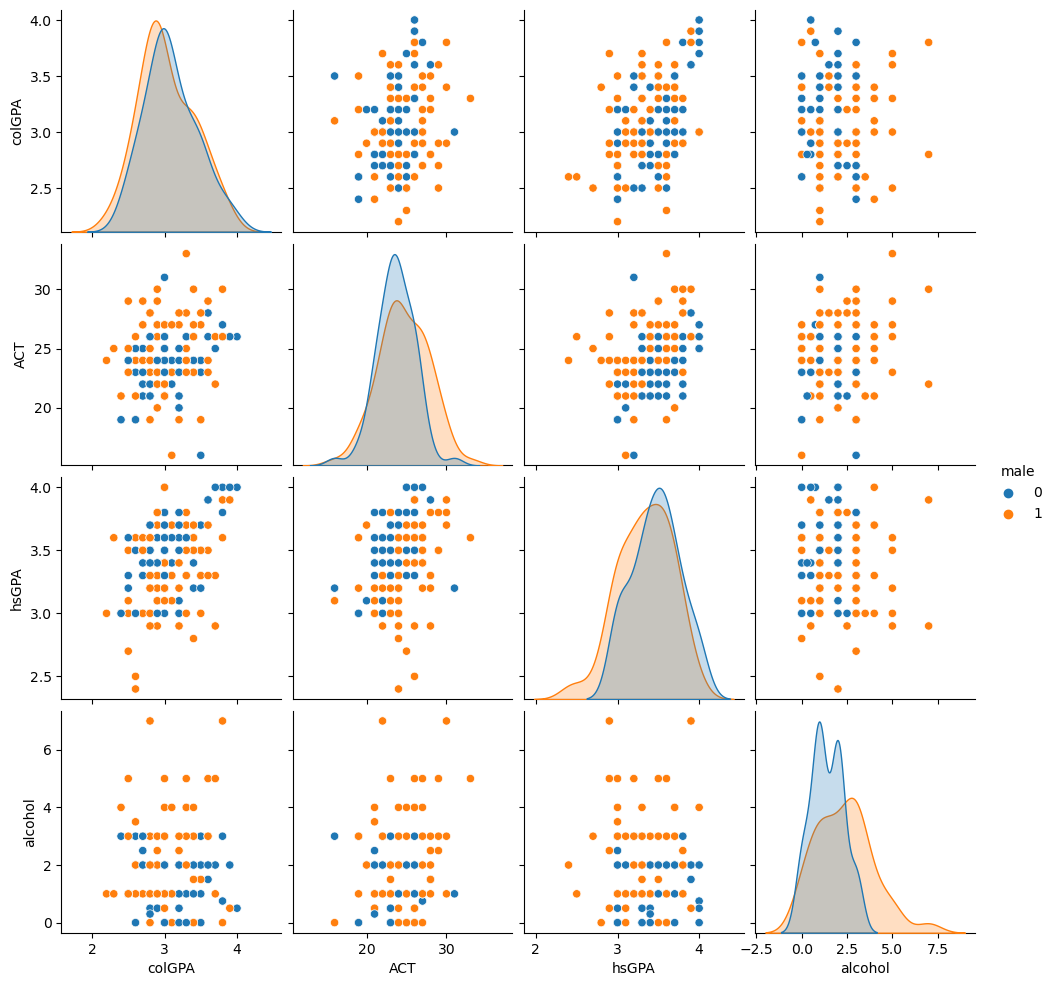

In [97]:
import seaborn as sns
sns.pairplot(df,vars=['colGPA','ACT', 'hsGPA','alcohol'], hue =  'male')

## 3) Look at the correlation plot

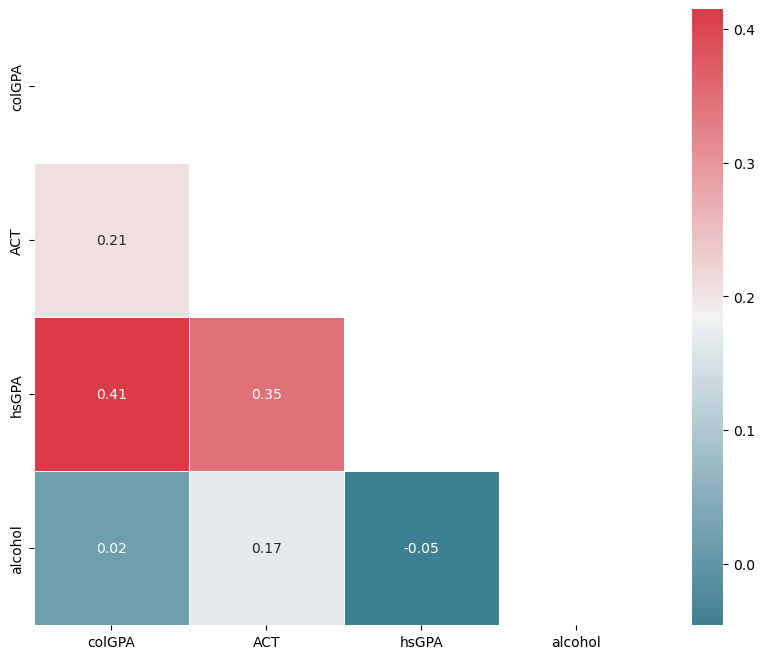

In [98]:
sub_df =  df[["colGPA", "ACT", "hsGPA", "alcohol"]]
corr = sub_df.corr()
fig, ax = plt.subplots(figsize=(10, 8))
colormap = sns.diverging_palette(220, 10, as_cmap = True)
dropvals = np.zeros_like(corr)
dropvals[np.triu_indices_from(dropvals)] = True
sns.heatmap(corr, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals)
plt.show()

## 4) Fit a Multiple Regression Model

In [99]:
# Specify the Model
mr_mod = smf.ols(formula='colGPA ~ hsGPA + ACT + alcohol', data=df)


mr_fit = mr_mod.fit()
# Type: dir(ols_fit) to look at other accessible attributes
# Fit the Model
# Type: dir(ols_fit) to look at other accessible attributes

# Look at the Model Fit Summary
print(mr_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 colGPA   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     9.819
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           6.56e-06
Time:                        08:50:43   Log-Likelihood:                -46.526
No. Observations:                 141   AIC:                             101.1
Df Residuals:                     137   BIC:                             112.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2787      0.343      3.729      0.0

In [100]:
from sklearn.preprocessing import PowerTransformer
#pt = PowerTransformer(method='box-cox')
#data3 = pt.fit_transform(df[:, :-1])
pt = PowerTransformer()
data3 = pt.fit_transform(df)
print(pt.lambdas_)

[-6.28174862e+00 -6.78066654e+01 -2.09614098e+00  6.13931056e-02
 -1.56443798e+01  4.30375887e-01 -8.32263095e+00  6.69771697e+00
 -4.06840008e+01 -5.15974572e-01  2.52824810e+00  8.95710005e-01
 -1.56461843e+00 -8.32263095e+00 -6.69771717e+00 -2.51277599e+00
 -1.17936406e+00 -6.16579536e+00 -1.82741907e+00 -3.41181789e+00
  5.91846148e+00  2.26021667e+01 -4.30375798e-01  1.82741907e+00
 -2.38707187e-01  2.44741679e-01  1.12652448e+01  1.56461837e+00
  6.77784330e-01]


In [101]:
print(pt.transform(data3))

[[-1.66712974e+08 -9.94645868e+04 -1.42589341e+01 ... -2.56846367e+00
  -2.71998012e+00 -3.88642315e+00]
 [-1.66712974e+08 -9.94645868e+04 -1.42589341e+01 ... -2.56846367e+00
   4.51142336e-01  7.87593138e-01]
 [-1.03448563e+11 -9.94645868e+04  1.41539084e+00 ... -2.56846367e+00
   4.51142336e-01  7.87593138e-01]
 ...
 [-1.03448563e+11 -9.94645868e+04  1.41539084e+00 ... -2.56846367e+00
  -2.71998012e+00 -3.88642315e+00]
 [-1.03448563e+11 -9.94645868e+04  1.41539084e+00 ... -2.56846367e+00
  -2.71998012e+00  7.87593138e-01]
 [-1.66712974e+08 -9.94645868e+04 -1.42589341e+01 ... -2.56846367e+00
   4.51142336e-01  7.87593138e-01]]


## 5) Look at the diagnostic plots

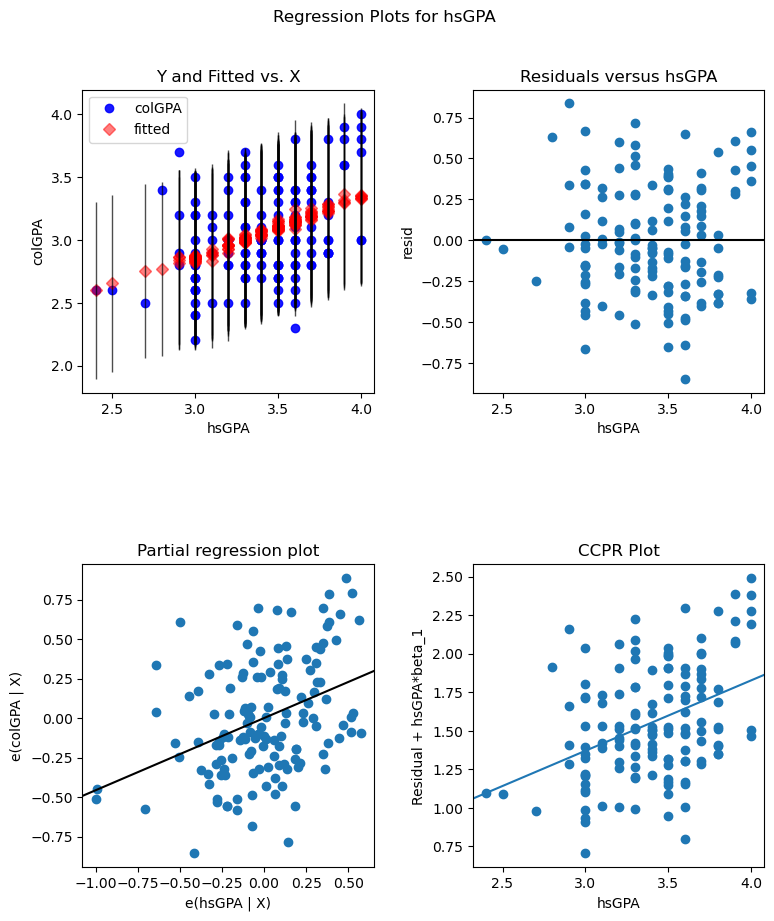

In [102]:
fig = sm.graphics.plot_regress_exog(mr_fit, "hsGPA")
fig.set_figheight(10)
fig.set_figwidth(8)
plt.show()

[Text(0.5, 36.72222222222221, 'Predicted'),
 Text(400.7790404040403, 0.5, 'Residuals')]

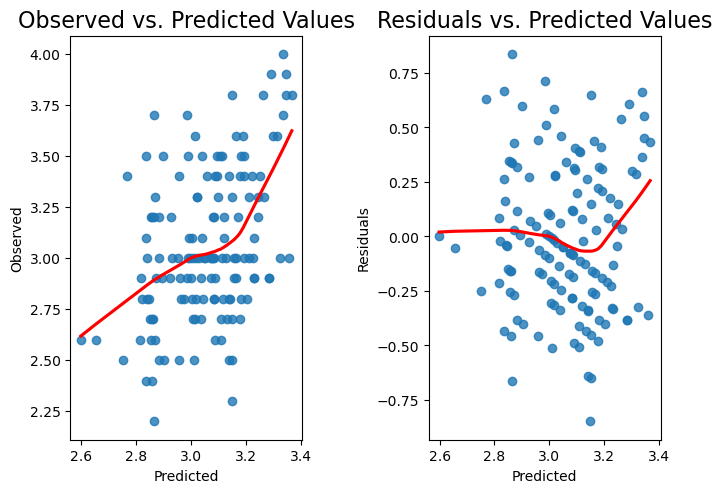

In [103]:
# Plot y vs y_hat
fig, ax = plt.subplots(1,2,figsize=(8, 6))
fig.tight_layout(pad=6.0)
sns.regplot(x=mr_fit.fittedvalues, y=df['colGPA'], lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
ax[0].set(xlabel='Predicted', ylabel='Observed')

sns.regplot(x=mr_fit.fittedvalues, y=mr_fit.resid, lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
ax[1].set(xlabel='Predicted', ylabel='Residuals')

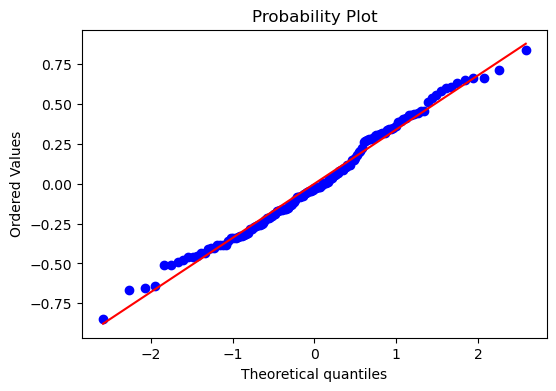

In [104]:
# QQ Plot (Normal Probability) 
import scipy as sp
figA, axA = plt.subplots(figsize=(6,4))
_, (__, ___, r) = sp.stats.probplot(mr_fit.resid, plot = axA, fit=True)

## Note: statsmodels 
If you would like to replicate the results from lecture based on Duncan's Prestige Dataset, see [statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html). Also, you can load and R dataset with `datasets.get_rdataset` also from `statsmodels`.

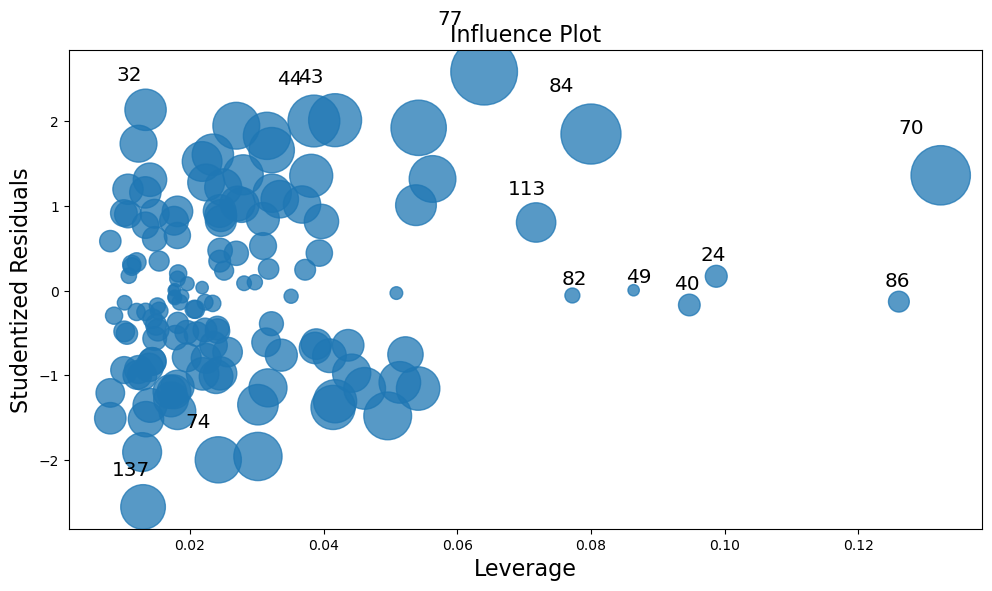

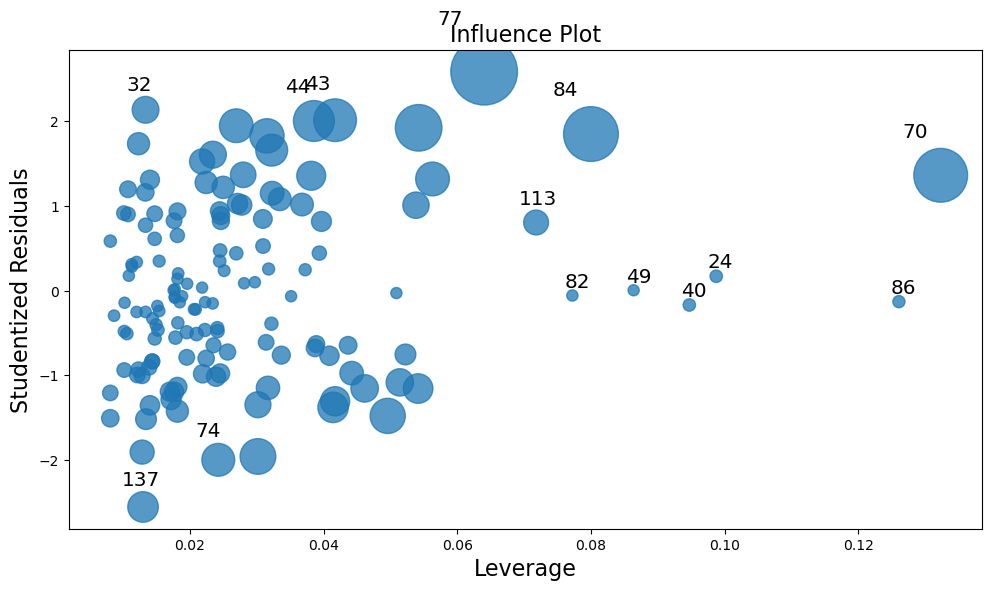

In [105]:
# Outliers, high leverage, influential obs
figd, ax = plt.subplots(figsize=(10,6))
figd = sm.graphics.influence_plot(mr_fit, ax = ax, criterion="DFFITS")
figd.tight_layout(pad=1.0)

fige, ax = plt.subplots(figsize=(10,6))
fige = sm.graphics.influence_plot(mr_fit, ax = ax, criterion="cooks")
fige.tight_layout(pad=1.0)

## 6) Look at modeling/inference issues

In [106]:
# VIF: Test for multicolinearity
import statsmodels.stats.outliers_influence as smo
import patsy as pt

# extract matrices using patsy:
y, X = pt.dmatrices('colGPA ~ hsGPA + ACT + alcohol',
                    data=df, return_type='dataframe')

# get VIF:
K = X.shape[1]
VIF = np.empty(K)
for i in range(K):
    VIF[i] = smo.variance_inflation_factor(X.values, i)
print(f'VIF: \n{VIF}\n')
# VIF values are low enough that multicolinearity does not seem to be an issue

VIF: 
[142.19442956   1.15044419   1.18179548   1.04266223]



In [107]:
# Heteroskedasticity: Breush-Pagan --> Ho: var = constant
import statsmodels.stats.api as sms
from simple_colors import *
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(mr_fit.resid, mr_fit.model.exog)
print(blue("BP Results:",['bold']))
print(list(zip(name, test)))
# Fail to reject Ho, therefore, heteroskedasticity does not appear to be an issue.

BP Results:
[('Lagrange multiplier statistic', 1.1124095297068033), ('p-value', 0.7740792499491603), ('f-value', 0.3631489756822434), ('f p-value', 0.7797099382125043)]


In [108]:
# Model Misspecification
#import numpy as np
import statsmodels.api as sm
#from statsmodels.stats.diagnostic import linear_reset

import statsmodels.stats.outliers_influence as oi

X= df[["hsGPA","alcohol","ACT"]]
y = df[["colGPA"]]

regression = sm.OLS(y, X)
result = regression.fit()
test = oi.reset_ramsey(result, degree=2)


print(blue("Ramsey-RESET:",['bold']))
print(test)
# Reject Ho, therefore, the model seems to be misspecified for order = 2.

Ramsey-RESET:
<F test: F=12.197638614164486, p=0.0006445865998442085, df_denom=137, df_num=1>


In [109]:
# Note: We can do an added sanity check by estimating two more models: 

#(a) include a quadratic term
print(blue("Quadratic Model",['bold']))
smf.ols(formula='colGPA ~ hsGPA + ACT + alcohol + I(hsGPA**2)', data = df).fit().summary()

Quadratic Model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 colGPA   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     8.002
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           8.00e-06
Time:                        08:50:43   Log-Likelihood:                -45.356
No. Observations:                 141   AIC:                             100.7
Df Residuals:                     136   BIC:                             115.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.8833      2.414      2.023      0.045       0.110       9.656
hsGPA            -1.6872      1.424     -1.185      0.238      -4.504       1.130
ACT               0.0066      0.011      0.593      0.554      -0.015       0.028
alcohol           0.0053      0.021      0.246      0.806      -0.037       0.047
I(hsGPA ** 2)     0.3207      0.213      1.509      0.134      -0.100       0.741
==============================================================================
Omnibus:                        4.138   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.126   Jarque-Bera (JB):                2.771
Skew:                           0.165   Prob(JB):                        0.250
Kurtosis:                       2.398   Cond. No.                     2.68e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [110]:
#(b) include an interation term
print(blue("Interaction Model",['bold']))
smf.ols(formula='colGPA ~ hsGPA + ACT + alcohol + hsGPA*alcohol', data = df).fit().summary()

Interaction Model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 colGPA   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     7.450
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           1.86e-05
Time:                        08:50:43   Log-Likelihood:                -46.289
No. Observations:                 141   AIC:                             102.6
Df Residuals:                     136   BIC:                             117.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.5631      0.543      2.879      0.005       0.489       2.637
hsGPA             0.3785      0.151      2.507      0.013       0.080       0.677
ACT               0.0079      0.011      0.713      0.477      -0.014       0.030
alcohol          -0.1275      0.199     -0.640      0.523      -0.521       0.266
hsGPA:alcohol     0.0398      0.059      0.676      0.500      -0.077       0.156
==============================================================================
Omnibus:                        2.550   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.279   Jarque-Bera (JB):                2.348
Skew:                           0.231   Prob(JB):                        0.309
Kurtosis:                       2.568   Cond. No.                         517.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [111]:
#y = df[["colGPA"]]
#print(y)

## 7) Prediction vs. Confidence Intervals

0.0
0.0
0.0


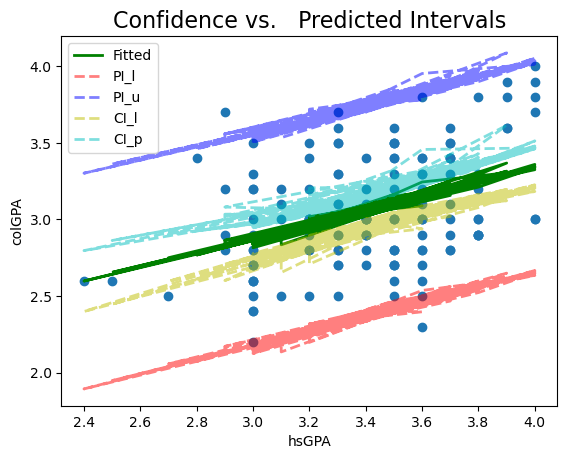

In [112]:
from statsmodels.stats.outliers_influence import summary_table
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import numpy as np
st, data, ss2 = summary_table(mr_fit, alpha=0.05)
prstd, iv_l, iv_u = wls_prediction_std(mr_fit)
fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T

# Check we got the right things
print(np.max(np.abs(mr_fit.fittedvalues - fittedvalues)))
print(np.max(np.abs(iv_l - predict_ci_low)))
print(np.max(np.abs(iv_u - predict_ci_upp)))
x = df['hsGPA']
y =  df['colGPA']
plt.plot(x, y, 'o')
plt.plot(x, fittedvalues, 'g-', lw=2, label = 'Fitted')
plt.plot(x, predict_ci_low, 'r--', lw=2,label ='PI_l', alpha = 0.5)
plt.plot(x, predict_ci_upp, 'b--', lw=2,label = 'PI_u', alpha = 0.5)
plt.plot(x, predict_mean_ci_low, 'y--', lw=2, label ='CI_l', alpha = 0.5)
plt.plot(x, predict_mean_ci_upp, 'c--', lw=2, label ='CI_p', alpha = 0.5)
plt.title('Confidence vs.   Predicted Intervals', fontsize=16)
plt.xlabel('hsGPA')
plt.ylabel('colGPA')
plt.legend()
plt.show()

## 8) Robust Estimation

In [113]:
# Compare the traditional SE vs. the  White SE
mr_mod = smf.ols(formula='colGPA ~ hsGPA + ACT + alcohol', data=df)

# estimate default model (only for spring data):
results_default = mr_mod.fit()

table_default = pd.DataFrame({'b': round(results_default.params, 5),
                              'se': round(results_default.bse, 5),
                              't': round(results_default.tvalues, 5),
                              'pval': round(results_default.pvalues, 5)})
print(f'Default Estimatws & Std. Errors: \n{table_default}\n')

# estimate model with White SE (only for spring data):
results_white = mr_mod.fit(cov_type='HC1')

table_white = pd.DataFrame({'b': round(results_white.params, 5),
                            'se': round(results_white.bse, 5),
                            't': round(results_white.tvalues, 5),
                            'pval': round(results_white.pvalues, 5)})
print(f'White Estimaets & Std. Errors: \n{table_white}\n')


Default Estimatws & Std. Errors: 
                 b       se        t     pval
Intercept  1.27871  0.34289  3.72925  0.00028
hsGPA      0.45674  0.09675  4.72099  0.00001
ACT        0.00877  0.01103  0.79521  0.42787
alcohol    0.00646  0.02143  0.30120  0.76372

White Estimaets & Std. Errors: 
                 b       se        t     pval
Intercept  1.27871  0.35813  3.57052  0.00036
hsGPA      0.45674  0.09857  4.63372  0.00000
ACT        0.00877  0.01096  0.79992  0.42376
alcohol    0.00646  0.02303  0.28028  0.77926



##  9) Weighted Least-Squares (known form of the variance)

In [114]:
# Estimate model:
mr_mod = smf.ols(formula='colGPA ~ hsGPA + ACT + alcohol', data=df)

results_ols= mr_mod.fit(cov_type='HC0')

table_ols = pd.DataFrame({'b': round(results_ols.params, 4),
                          'se': round(results_ols.bse, 4),
                          't': round(results_ols.tvalues, 4),
                          'pval': round(results_ols.pvalues, 4)})
print(f'table_ols: \n{table_ols}\n')

# WLS: here we use w = 1/x
wls_weight = list(1 / df['hsGPA'])
reg_wls = smf.wls(formula='colGPA ~ hsGPA + ACT + alcohol',
                  weights=wls_weight, data=df)
results_wls = reg_wls.fit()

# print regression table:
table_wls = pd.DataFrame({'b': round(results_wls.params, 4),
                          'se': round(results_wls.bse, 4),
                          't': round(results_wls.tvalues, 4),
                          'pval': round(results_wls.pvalues, 4)})
print(f'table_wls: \n{table_wls}\n')

table_ols: 
                b      se       t    pval
Intercept  1.2787  0.3530  3.6223  0.0003
hsGPA      0.4567  0.0972  4.7009  0.0000
ACT        0.0088  0.0108  0.8115  0.4171
alcohol    0.0065  0.0227  0.2843  0.7761

table_wls: 
                b      se       t    pval
Intercept  1.3358  0.3368  3.9660  0.0001
hsGPA      0.4423  0.0940  4.7080  0.0000
ACT        0.0086  0.0109  0.7871  0.4326
alcohol    0.0048  0.0212  0.2255  0.8219



##  10) Feasible Generalized Least-Squares (unknown form of the variance)

In [115]:
# estimate model:
mr_mod = smf.ols(formula='colGPA ~ hsGPA + ACT + alcohol', data=df)
results_ols= mr_mod.fit()

# FGLS (estimation of the variance function):
df['logu2'] = np.log(results_ols.resid ** 2)
reg_fgls = smf.ols(formula='logu2 ~ np.log(hsGPA) + np.log(ACT)', data=df)
results_fgls = reg_fgls.fit()
table_fgls = pd.DataFrame({'b': round(results_fgls.params, 4),
                           'se': round(results_fgls.bse, 4),
                           't': round(results_fgls.tvalues, 4),
                           'pval': round(results_fgls.pvalues, 4)})
print(f'FGLS (Variance Function): \n{table_fgls}\n')

# FGLS (WLS):
wls_weight = list(1 / np.exp(results_fgls.fittedvalues))
reg_wls = smf.wls(formula='colGPA ~ hsGPA + ACT + alcohol',
                  weights=wls_weight, data=df)
results_wls = reg_wls.fit()
table_wls = pd.DataFrame({'b': round(results_wls.params, 4),
                          'se': round(results_wls.bse, 4),
                          't': round(results_wls.tvalues, 4),
                          'pval': round(results_wls.pvalues, 4)})
print(f'FGLS Estimates: \n{table_wls}\n')

FGLS (Variance Function): 
                     b      se       t    pval
Intercept     -10.0610  5.0227 -2.0031  0.0471
np.log(hsGPA)   6.4048  2.0590  3.1106  0.0023
np.log(ACT)    -0.3590  1.6582 -0.2165  0.8289

FGLS Estimates: 
                b      se       t    pval
Intercept  1.4350  0.3215  4.4633  0.0000
hsGPA      0.4152  0.0776  5.3477  0.0000
ACT        0.0088  0.0104  0.8526  0.3954
alcohol   -0.0031  0.0196 -0.1580  0.8747



In [116]:
#### Applying FGLS to the 'food' data
food = pd.read_csv('food.csv')
mols = smf.ols('food_exp ~ income', data = food).fit()

ehatsq = mols.resid**2
sigols  = smf.ols('np.log(ehatsq) ~ np.log(income)', data = food).fit()

vari = np.exp(sigols.fittedvalues) 

w = 1/vari

fgls = smf.wls('food_exp ~ income', weights = w, data = food).fit()
print(fgls .summary())

                            WLS Regression Results                            
Dep. Variable:               food_exp   R-squared:                       0.759
Model:                            WLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     119.8
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           2.62e-13
Time:                        08:50:44   Log-Likelihood:                -226.14
No. Observations:                  40   AIC:                             456.3
Df Residuals:                      38   BIC:                             459.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     76.0538      9.713      7.830      0.0

In [117]:
print(sigols.summary())
# Note: gamma = 2.32

                            OLS Regression Results                            
Dep. Variable:         np.log(ehatsq)   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     18.51
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           0.000114
Time:                        08:50:44   Log-Likelihood:                -77.445
No. Observations:                  40   AIC:                             158.9
Df Residuals:                      38   BIC:                             162.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9378      1.583      0.

In [118]:
# Goldfeld-Quandt test with two groups

import scipy.stats as stats # Statistics

cps5_small = pd.read_csv('cps5_small.csv')

alpha = 0.05 # Two tail, will take alpha/2

# Create the two groups, m (metro) and r (rural)

m = cps5_small[cps5_small.metro == 1]

r = cps5_small[cps5_small.metro == 0]

wg1 = smf.ols('wage ~ educ + exper', data = m).fit()

wg0 = smf.ols('wage ~ educ + exper', data = r).fit()

df1 = wg1.df_resid # Numerator degrees of freedom

df0 = wg0.df_resid # Denominatot df

sig1squared = wg1.scale**2

sig0squared = wg0.scale**2

fstat = sig1squared / sig0squared
print('F_stat =',round(fstat,2))

Flc = stats.f.ppf(alpha/2, df1, df0) # Left critical F
print('F_lc =', round(Flc,2))

Fuc = stats.f.ppf(1-alpha/2, df1, df0) # Right critical F
print('F_uc =', round(Fuc,2))

F_stat = 5.36
F_lc = 0.82
F_uc = 1.24


#  Mallows Cp
See [regstore](https://pypi.org/project/RegscorePy/). You need to install `RegscorePy`.

`pip install RegscorePy`. 

For stepwise regression, please see this [lab](http://www.science.smith.edu/~jcrouser/SDS293/labs/lab8-py.html). Finally, for general regression plots, etc., you can go to [statsmodels](https://www.statsmodels.org/stable/examples/index.html#glm).